In [1]:
# All Imports

import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import filters
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from skimage.measure import compare_ssim as ssim



import numba
from numba import njit, prange

from keras import backend as K
from keras.layers import Layer

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf


from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy


import os
import glob
import uuid
import numpy as np
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from ipdb import set_trace as bp



#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time



Using TensorFlow backend.


In [2]:
# Ray Tracing Code


@njit(parallel=True)
def x_y_flip(host_prjbuf_temp):
    host_prjbuf_temp_gpu  = np.copy(host_prjbuf_temp)
    host_prjbuf_1view_gpu = np.copy(host_prjbuf_temp)
    
    for i in prange(BINSx):
        for j in prange(BINSy):
            bin_ind_temp = j*BINSx+i
            bin_ind      = i*BINSy+j
            host_prjbuf_1view_gpu[bin_ind] = host_prjbuf_temp_gpu[bin_ind_temp]
    
    return host_prjbuf_1view_gpu

@njit(parallel=True)
def compute_yry(host_prj_allangle, host_scat_allangle):
    all_b_size        =  ANGLES*BINSx*BINSy
    host_yry_allangle =  np.zeros(BINSx*BINSy*ANGLES)
    
    for i in prange(all_b_size):
        if (host_prj_allangle[i] == 0):
            host_yry_allangle[i] = 0
        else:
            dif = host_prj_allangle[i] - host_scat_allangle[i]
            if (dif <= 0):
                dif = host_prj_allangle[i]
            host_yry_allangle[i] = (dif*dif)/host_prj_allangle[i]
    
    return host_yry_allangle

@njit(parallel=True)
def compute_gamma_yry(host_yry_allangle, host_gamma_allangle):
    all_b_size              = ANGLES*BINSx*BINSy
    host_gamma_yry_allangle = np.zeros(all_b_size)
    
    for i in prange(all_b_size):
        host_gamma_yry_allangle[i] = host_yry_allangle[i]*host_gamma_allangle[i]
    
    return host_gamma_yry_allangle

@njit(parallel=True)
def compute_h(host_prj_sub, host_blank_sub, host_line_sub, host_scat_sub):
    ANGLES_per_sub  = int(ANGLES/subset_num)
    sub_b_size      = int(ANGLES_per_sub*BINSx*BINSy)
    
    host_sub = np.zeros(sub_b_size)
    
    for i in prange(sub_b_size):
        y_tmp       = host_blank_sub[i]*np.exp(-host_line_sub[i])
        host_sub[i] = (host_prj_sub[i]/(y_tmp+host_scat_sub[i])-1)*y_tmp
    
    return host_sub

@njit(parallel=True)
def update_est(host_est, host_capL, host_RD, host_d, host_RDD):
    f_size    = IMGSIZx*IMGSIZy*IMGSIZz
    host_est1 = np.zeros(f_size)
    
    for i in prange(f_size):
        host_est1[i] = host_est[i]-(host_capL[i]+beta*host_RD[i])/(host_d[i]+2*beta*host_RDD[i])
        if (host_est1[i] < 0):
            host_est1[i] = 0
    
    return host_est1

@njit(parallel=True)
def regroup_prj(host_uponregroup_allangle):
    all_b_size     = int(ANGLES*BINSx*BINSy)
    ANGLES_per_sub = int(ANGLES/subset_num)
    b_size         = int(BINSx*BINSy)
    
    host_allangle_tmp = np.zeros(host_uponregroup_allangle.shape)
    flag              = 0
    
    for i in range(subset_num):
        for j in range(ANGLES_per_sub):
            for k in range(b_size):
                host_allangle_tmp[flag] = host_uponregroup_allangle[int((j*subset_num+i)*b_size+k)]
                flag = flag +1
    
    return host_allangle_tmp

import math

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory_normprj(d_normprj, x0, y0, z0, x1, y1, z1, status, sum_norm, bin_ind):
    # Perform Ray Tracing
    sum_norm = 0
    dx     = x1-x0
    dy     = y1-y0
    dz     = z1-z0
    Length = math.sqrt( dx*dx+dy*dy+dz*dz )


    if (x1 != x0):
        min_lx = (x_p0-x0)/dx
        max_lx = min_lx+IMGSIZx*Vsize_x/dx

        if (min_lx > max_lx):
            #SWAP(min_lx, max_lx);
            s_temp = min_lx
            min_lx = max_lx
            max_lx = s_temp
    else:
        # the line perpendicular to x axis
        if (x0 >= IMGSIZx*Vsize_x+x_p0 or x0<=x_p0):
            status = -1
            return
        min_lx = -1e3
        max_lx = 1e3
    
    
    if (y0 != y1):
        min_ly = (y_p0-y0)/dy
        max_ly = min_ly+IMGSIZy*Vsize_y/dy

        if (min_ly > max_ly):
            #SWAP(min_ly, max_ly);
            s_temp = min_ly
            min_ly = max_ly
            max_ly = s_temp
    else:
        # the line perpendicular to y axis
        if (y0 >= IMGSIZy*Vsize_y+y_p0 or y0 <= y_p0):
            status = -1
            return
        min_ly = -1e3
        max_ly = 1e3

    
    if (z0 != z1):
        min_lz = (z_p0-z0)/dz
        max_lz = min_lz+IMGSIZz*Vsize_z/dz
        if (min_lz > max_lz):
            #SWAP(min_lz, max_lz);
            s_temp = min_lz
            min_lz = max_lz
            max_lz = s_temp
    else:
        # the line perpendicular to z axis
        if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
            status = -1
            return
        min_lz = -1e3
        max_lz = 1e3
    
    
    max_l = max_lx
    if (max_l > max_ly):
        max_l=max_ly
    if (max_l > max_lz):
        max_l = max_lz

    min_l = min_lx
    if (min_l < min_ly):
        min_l = min_ly
    if (min_l < min_lz):
        min_l = min_lz

    if (min_l >= max_l):
        status = -1
        return
    
    if (min_lx != min_l):
        prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))

        if (x0 < x1):
            min_lx= ((prev_x+1)*Vsize_x+x_p0-x0)/ dx
        else:
            if (x0 == x1):
                min_lx = 1e3
            else:
                min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
    else:
        if (x0 < x1):
            prev_x = 0
            min_lx = ( Vsize_x+x_p0-x0 )/ dx
        else:
            prev_x = IMGSIZx-1
            min_lx = ( prev_x*Vsize_x+x_p0-x0 )/ dx
    
    if (min_ly != min_l):
        prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/Vsize_y ))
        if (y0 < y1):
            min_ly = ( (prev_y+1)*Vsize_y+y_p0-y0)/ dy
        else:
            if (y0==y1):
                min_ly = 1e3
            else:
                min_ly = (prev_y*Vsize_y+y_p0-y0)/ dy
    else:
        if (y0<y1):
            prev_y = 0
            min_ly = ( Vsize_y+y_p0-y0 )/ dy
        else:
            prev_y = IMGSIZy-1
            min_ly = ( prev_y*Vsize_y+y_p0-y0 )/ dy
    
    if (min_lz != min_l):
        prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/Vsize_z ))
        if (z0 < z1):
            min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
        else:
            if (z0 == z1):
                min_lz = 1e3
            else:
                min_lz = (prev_z*Vsize_z+z_p0-z0)/ dz
    else:
        if (z0 < z1):
            prev_z = 0
            min_lz = ( Vsize_z+z_p0-z0 )/ dz
        else:
            prev_z = (int)(IMGSIZz-1)
            min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
    
    
    min_l_new = min_lx
    if (min_l_new > min_ly):
        min_l_new = min_ly
    if (min_l_new > min_lz):
        min_l_new = min_lz
    
    incx = Vsize_x/dx
    incy = Vsize_y/dy
    incz = Vsize_z/dz

    ind = 0
    
    while ( (max_l-min_l_new)/max_l > 0.000001):
        tmp_length = (min_l_new-min_l)*Length; #<-a_ij
        if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        ind = ind + 1
        if (min_l_new == min_lx):
            if (x0 < x1):
                prev_x = prev_x + 1
                min_lx = min_lx + incx; #Vsize_x/dx
            else:
                prev_x = prev_x - 1
                min_lx = min_lx - incx; #Vsize_x/dx;
        else:
            prev_x = prev_x


        if (min_l_new == min_ly):
            if (y0 < y1):
                prev_y = prev_y + 1
                min_ly = min_ly + incy; #Vsize_y / dy;
            else:
                prev_y = prev_y - 1
                min_ly = min_ly- incy; #Vsize_y/dy;
        else:
            prev_y = prev_y


        if (min_l_new == min_lz):
            if (z0 < z1):
                prev_z = prev_z + 1
                min_lz = min_lz + incz #Vsize_z/dz;
            else:
                prev_z = prev_z - 1
                min_lz = min_lz - incz; #Vsize_z/dz
        else:
            prev_z = prev_z

        min_l     = min_l_new
        min_l_new = min_lx

        if (min_l_new > min_ly):
            min_l_new = min_ly

        if (min_l_new>min_lz):
            min_l_new=min_lz
        
        
        tmp_length = (max_l-min_l)*Length
        if ((prev_x>=0) and (prev_x<IMGSIZx) and (prev_y>=0) and (prev_y<IMGSIZy) and (prev_z>=0) and (prev_z<IMGSIZz)):
            sum_norm = sum_norm + 1*tmp_length
        
        d_normprj[bin_ind] = sum_norm

@cuda.jit(device=True)
def rayTrace3D_GPU_direct_notexturememory(d_normprj, d_prjbuf, d_objbuf, x0, y0, z0, x1, y1, z1, status):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        
        d_normprj[bin_ind] = 0
        d_prjbuf[bin_ind]  = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz
            
            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz
            
            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
                
                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum
        
        cuda.syncthreads()
    
@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    #sum_norm = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY

        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        d_normprj[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + 1*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + 1*tmp_length
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = sum_norm
        #else:
        #    d_normprj[bin_ind] = sum_norm
#         elif status == 10:
#             d_normprj[bin_ind] = 100000
#         elif status == -1:
#             d_normprj[bin_ind] = 50000
#         else:
#             d_normprj[bin_ind] = 200000
#         d_normprj[bin_ind] = Length
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos(d_objbuf, d_prjbuf, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        sum_norm = 0.0
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                sum_norm = sum_norm + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            status2 = 100
        
        if status2 == 100:
            d_prjbuf[bin_ind] = sum_norm*cos_theta
        cuda.syncthreads()

@cuda.jit
def ray_trace_gpu_manyangles_direct_notexturememory_cos(d_objbuf, d_prjbuf, d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    status   = 0
    
    for a in range(angleStart, angleEnd):
        #print(a)
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        x0        = sourceR*sin_theta
        z0        = sourceR*cos_theta
        y0        = sourceY
        
        # calculate bin index
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy

        bin_x_pos = (x_d0+(i+0.5)*Bsize_x)
        bin_y_pos = (y_d0+(j+0.5)*Bsize_y)

        x1 =  bin_x_pos
        z1 = -detectorR
        y1 =  bin_y_pos

        # Iso-centric version
        # x1 =  bin_x_pos*cos_theta-detectorR*sin_theta
        # z1 = -bin_x_pos*sin_theta-detectorR*cos_theta
        # y1 =  bin_y_pos

        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        y0 = sourceY
        
        # Perform Ray Tracing
        fsum_norm = 0.0
        fsum      = 0.0
        
        dx     = x1-x0
        dy     = y1-y0
        dz     = z1-z0
        Length = math.sqrt( dx*dx + dy*dy + dz*dz )
        #d_prjbuf[bin_ind] = 0
        
        if (x1 != x0):
            min_lx = (x_p0 - x0)/dx
            max_lx = min_lx + (IMGSIZx*Vsize_x)/dx
            if (min_lx > max_lx):
                #SWAP(min_lx, max_lx);
                s_temp = min_lx
                min_lx = max_lx
                max_lx = s_temp
        else:
            # the line perpendicular to x axis
            if ((x0 >= IMGSIZx*Vsize_x+x_p0) or x0 <= x_p0):
                status = -1
            min_lx = -1000.0
            max_lx =  1000.0
        
        if (y0 != y1):
            min_ly = (y_p0-y0)/dy
            max_ly = min_ly + IMGSIZy*Vsize_y/dy
            if (min_ly > max_ly):
                #SWAP(min_ly, max_ly);
                s_temp = min_ly
                min_ly = max_ly
                max_ly = s_temp
        else:
            # the line perpendicular to y axis
            if (y0 >= IMGSIZy*Vsize_y + y_p0 or y0 <= y_p0):
                status = -1
            min_ly = -1000.0
            max_ly =  1000.0
        
        if (z0 != z1):
            min_lz = (z_p0 - z0)/dz
            max_lz = min_lz + IMGSIZz*Vsize_z/dz
            if (min_lz > max_lz):
                #SWAP(min_lz, max_lz);
                s_temp = min_lz
                min_lz = max_lz
                max_lz = s_temp
        else:
            # the line perpendicular to z axis
            if (z0 >= IMGSIZz*Vsize_z+z_p0 or z0 <= z_p0):
                status = -1
            min_lz = -1000.0
            max_lz =  1000.0
        
        max_l = max_lx
        if (max_l > max_ly):
            max_l = max_ly
        if (max_l > max_lz):
            max_l = max_lz
        
        min_l = min_lx
        if (min_l < min_ly):
            min_l = min_ly
        if (min_l < min_lz):
            min_l = min_lz
        
        if (min_l >= max_l):
            status1 = 10
            #d_normprj[bin_ind] = 1
        else:
            status1 = 0
        
        if status1 != 10:
            if (min_lx != min_l):
                prev_x = (int)(math.floor( (min_l* dx + x0 - x_p0) / Vsize_x ))
                if (x0 < x1):
                    min_lx = ((prev_x+1)*Vsize_x+x_p0 - x0)/ dx
                elif (x0 == x1):
                    min_lx = 1000
                else:
                    min_lx = (prev_x*Vsize_x+x_p0-x0) / dx
                #d_normprj[bin_ind] = Vsize_x
            else:
                if (x0 < x1):
                    prev_x = 0
                    min_lx = ( Vsize_x+x_p0-x0 )/ dx
                else:
                    prev_x = IMGSIZx-1
                    min_lx = ( prev_x*Vsize_x + x_p0 - x0 )/ dx
            #d_normprj[bin_ind] = prev_x
                
            if (min_ly != min_l):
                prev_y = (int)(math.floor( (min_l* dy + y0 - y_p0)/ Vsize_y ))
                if (y0 < y1):
                    min_ly = ( (prev_y+1)*Vsize_y + y_p0 - y0)/ dy
                elif (y0 == y1):
                    min_ly = 1000
                else:
                    min_ly = (prev_y*Vsize_y + y_p0 - y0)/ dy
            else:
                if (y0 < y1):
                    prev_y = 0
                    min_ly = ( Vsize_y+y_p0-y0 )/ dy
                else:
                    prev_y = IMGSIZy-1
                    min_ly = ( prev_y*Vsize_y + y_p0 - y0 )/ dy
                
            if (min_lz != min_l):
                prev_z = (int)(math.floor( (min_l* dz + z0 - z_p0)/ Vsize_z ))
                if (z0 < z1):
                    min_lz = ( (prev_z+1)*Vsize_z+z_p0-z0)/ dz
                elif (z0 == z1):
                    min_lz = 1000
                else:
                    min_lz = (prev_z*Vsize_z + z_p0 - z0)/ dz
            else:
                if (z0 < z1):
                    prev_z = 0
                    min_lz = ( Vsize_z + z_p0 - z0 )/ dz
                else:
                    prev_z = (int)(IMGSIZz-1)
                    min_lz = ( prev_z*Vsize_z+z_p0-z0 )/dz
            
            min_l_new = min_lx
            if (min_l_new > min_ly):
                min_l_new = min_ly
            if (min_l_new > min_lz):
                min_l_new = min_lz


            incx = Vsize_x/dx
            incy = Vsize_y/dy
            incz = Vsize_z/dz

            ind = 0
            #d_normprj[bin_ind] = max_l
            while ( (max_l-min_l_new)/max_l > 0.000001):
                tmp_length = (min_l_new - min_l)*Length
                if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                    fsum_norm      = fsum_norm + 1*tmp_length
                    fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length

                ind = ind + 1
                if (min_l_new == min_lx):
                    if (x0 < x1):
                        prev_x = prev_x + 1
                        min_lx = min_lx + incx #Vsize_x/dx
                    else:
                        prev_x = prev_x - 1
                        min_lx = min_lx - incx #Vsize_x/dx;
                else:
                    prev_x = prev_x

                if (min_l_new == min_ly):
                    if (y0 < y1):
                        prev_y = prev_y + 1
                        min_ly = min_ly + incy #Vsize_y / dy;
                    else:
                        prev_y = prev_y - 1
                        min_ly = min_ly- incy #Vsize_y/dy;
                else:
                    prev_y = prev_y

                if (min_l_new == min_lz):
                    if (z0 < z1):
                        prev_z = prev_z + 1
                        min_lz = min_lz + incz #Vsize_z/dz;
                    else:
                        prev_z = prev_z - 1
                        min_lz = min_lz - incz; #Vsize_z/dz
                else:
                    prev_z = prev_z

                min_l     = min_l_new
                min_l_new = min_lx

                if (min_l_new > min_ly):
                    min_l_new = min_ly

                if (min_l_new > min_lz):
                    min_l_new = min_lz
            
            tmp_length = (max_l - min_l)*Length
            if ((prev_x >= 0) and (prev_x < IMGSIZx) and (prev_y >= 0) and (prev_y < IMGSIZy) and (prev_z >= 0) and (prev_z < IMGSIZz)):
                fsum_norm      = fsum_norm + 1*tmp_length
                fsum           = fsum + d_objbuf[(prev_z*IMGSIZy+prev_y)*IMGSIZx+prev_x]*tmp_length
            
            status2 = 100
        if status2 == 100:
            d_normprj[bin_ind] = fsum_norm
            d_prjbuf[bin_ind]  = fsum*cos_theta
        
        cuda.syncthreads()
    
def fprojectCB_1R_GPU_OSTR_normprj(d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_normprj[PRJ_GRID, PRJ_THREAD](d_normprj, d_angles, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            #cuda.synchronize()
    return

def fprojectCB_1R_GPU_OSTR_cos(estbuf, prj_est, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_OSTR_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_angles, d_index, 
                                                                                           angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return

def fprojectCB_1R_GPU_SART_cos(estbuf, prj_est, d_normprj, d_angles, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            ray_trace_gpu_manyangles_direct_notexturememory_cos[PRJ_GRID, PRJ_THREAD](estbuf, prj_est, d_normprj, d_angles, 
                                                                                      d_index, angleStart, angleEnd, 
                                                                                      nbBinsX, nbBinsY)
            cuda.synchronize()
    return

@cuda.jit
def SART_prj_diff_kernel(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY):
    ix, iy   = cuda.grid(2)
    
    # calculate bin index
    for a in range(angleStart, angleEnd):
        i = nbBinsX*((int)(BINSx/nBatchBINSx)) + ix
        j = nbBinsY*((int)(BINSy/nBatchBINSy)) + iy
        
        bin_ind = ((a-angleStart)*BINSx+i)*BINSy+j
        
        if normprj[bin_ind] != 0:
            diff_line[bin_ind] = prjbuf[bin_ind]#bin_ind#(prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            diff_line[bin_ind] = bin_ind#1
    return

@njit(parallel=True)
def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    result_diff_line = np.zeros(prjbuf.shape)
    
    #for nbBinsX in prange(nBatchBINSx):
    #    for nbBinsY in prange(nBatchBINSy):
    for bin_ind in prange(prjbuf.shape[0]):
        if normprj[bin_ind] != 0:
            result_diff_line[bin_ind] = (prjbuf[bin_ind] - prj_est[bin_ind])/normprj[bin_ind]
        else:
            result_diff_line[bin_ind] = 0.0#prjbuf[bin_ind]#bin_ind
    
    return result_diff_line

#@njit(parallel=True)
def SART_prj_diff_old(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):
    PRJ_THREAD = PRJ_ThreX, PRJ_ThreY
    PRJ_GRID   = PRJ_GridX, PRJ_GridY
    
    for nbBinsX in range(nBatchBINSx):
        for nbBinsY in range(nBatchBINSy):
            SART_prj_diff_kernel[PRJ_GRID, PRJ_THREAD](diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd, nbBinsX, nbBinsY)
            cuda.synchronize()
    return
#SART_prj_diff_kernel<<<PRJ_GRID,PRJ_THREAD>>>(diff_line,prjbuf,prj_est,normprj,d_index,angleStart,angleEnd,nbBinsX,nbBinsY);
#CUT_CHECK_ERROR("Kernel execution failed");
#cudaThreadSynchronize()

#def SART_prj_diff(diff_line, prjbuf, prj_est, normprj, d_index, angleStart, angleEnd):

#@cuda.jit
def bprojectCB_4B_GPU_R_SART(d_objbuf, d_prjbuf, d_prior, d_index, 
                                   d_angles, angleStart, angleEnd, lambda_parameter, beta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_OSSART_gpu_manyviews_R[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_prior, d_index, 
                                                                            d_angles, angleStart, angleEnd , nbatchIDx, lambda_parameter, beta)
        cuda.synchronize()
    return

@cuda.jit
def backprj_OSSART_gpu_manyviews_R(d_objbuf, d_prjbuf, d_prior, d_index, d_angles, 
                                          angleStart, angleEnd, nbatchIDx, lambda_parameter, beta):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum         = 0.0
    total_sensitivity = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0+y0*y0+z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        #Do NOT Rotate (x0,y0,z0)  -theta  around the y-axis
        y0r =y0
        x0r =x0
        z0r =z0
        
        #Do NOT Rotate (x1,y1,z1)  -theta around the y-axis
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1
            
            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            d1_sen = 0
            d2_sen = 0
        
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = (1-fracI) 

            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d1_sen  = d1_sen + fracI 

            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen   =  1-fracI 

            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
                d2_sen = d2_sen + fracI
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            
            u_sensitivity = ((1-fracJ)*d1_sen+fracJ*d2_sen)
            u_sensitivity = u_sensitivity *Vsize_z*depth_weight
            
            total_sum         = total_sum + (u_term*weight)
            total_sensitivity = total_sensitivity+(u_sensitivity*weight)
    
    u_term    = 0
    beta_term = 0
    
    if(total_sensitivity != 0):
        u_term    = (total_sum/total_sensitivity)
        beta_term = (beta*d_prior[ind_voxel])/total_sensitivity
    
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+lambda_parameter*(u_term+beta_term)
    if(d_objbuf[ind_voxel] < 0):
        d_objbuf[ind_voxel] = 0
    #if(d_objbuf[ind_voxel] > 0.1):
    #    d_objbuf[ind_voxel] = 0
    
    return

@cuda.jit
def backprj_gpu_manyviews_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx):
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    tid = tx
    
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = (ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x
    
    total_sum = 0.0
    
    for a in range(angleStart, angleEnd):
        u_term    = 0.0
        
        s         = d_index[a]
        theta     = d_angles[s]
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)
        
        #(x0,y0,z0) - source position
        x0 = sourceR*sin_theta
        z0 = sourceR*cos_theta
        y0 = sourceY
        
        #(x1,y1,z1) - center of voxel
        x1 = (ind_x+0.5)*Vsize_x + x_p0
        y1 = (ind_y+0.5)*Vsize_y + y_p0
        z1 = (ind_z+0.5)*Vsize_z + z_p0
        
        #Check FDK paper for this weight factor. This weight can be set to 1, in a simple case
        depth_weight = (x0*x0 + y0*y0 + z0*z0)/((x0-x1)*(x0-x1) + (y0-y1)*(y0-y1)+(z0-z1)*(z0-z1))
        
        y0r = y0
        x0r = x0
        z0r = z0
        
        y1r = y1
        z1r = z1
        x1r = x1
        
        if (z1r != z0r):
            t = (-detectorR - z0r) / (z1r - z0r)
            x2 = x0r + (x1r - x0r) * t
            y2 = y0r + (y1r - y0r) * t
            
            weight = 1.0
            
            # BACKPROJECTION USING INTERPOLATION
            # Calculate the continuous position (in bin_index coordinate) of the projection of voxel in the detector plane.
            imb = ((float)(x2 - x_d0)/Bsize_x)
            jmb = ((float)(y2 - y_d0)/Bsize_y)
            
            ilb = (float)(math.floor(imb))
            if (imb < (ilb+0.5)):
                ilb = ilb - 1
            
            jlb = (float)(math.floor(jmb))
            if ( jmb < (jlb+0.5)):
                jlb = jlb - 1

            fracI = imb - (ilb+0.5)
            fracJ = jmb - (jlb+0.5)
            
            d1 = 0
            d2 = 0
            
            # Interpolation
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = ilb*BINSy + jlb
                d1      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx-1) and (ilb >= -1) and (jlb < BINSy) and (jlb >= 0)):
                bin_ind = (ilb + 1)* BINSy+ jlb
                d1      = d1 + fracI * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb < BINSx) and (ilb >= 0) and (jlb < BINSy-1) and (jlb >= -1)):
                bin_ind = ilb* BINSy + jlb + 1
                d2      = (1-fracI) * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            if ((ilb<BINSx-1) and (ilb>=-1) and (jlb<BINSy-1) and (jlb>=-1)):
                bin_ind = (ilb + 1) * BINSy +  jlb + 1
                d2 = d2 + fracI  * d_prjbuf[int((a-angleStart)*BINSx*BINSy + bin_ind)]
            
            u_term    = (1 - fracJ) * d1 + fracJ * d2
            u_term    = u_term*Vsize_z*depth_weight
            total_sum = total_sum + (u_term*weight)
        
    d_objbuf[ind_voxel] = d_objbuf[ind_voxel]+total_sum        
    return


def bprojectCB_GPU_SBP(d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    for nbatchIDx in range(nBatchXdim):
        backprj_gpu_manyviews_SBP[BACKPRJ_GRID, BACKPRJ_THREAD](d_objbuf, d_prjbuf, d_index, d_angles, angleStart, angleEnd , nbatchIDx)
        cuda.synchronize()
    return

@njit(parallel=True)
def temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle):
    host_prj_sub = np.zeros(sub_b_size)
    for i in prange(sub_b_size):
        host_prj_sub[i]   = host_prj_allangle[angleStart*b_size+i]
    return host_prj_sub

@njit(parallel=True)
def temp_fun2(subset_num, f_size, host_capL):
    temp = np.zeros(f_size)
    for i in prange(f_size):
        temp[i] = subset_num*host_capL[i]
    return temp

@cuda.jit
def G_Fessler_prior(RDD, RD, estbuf, delta, z_xy_ratio, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel=int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)*z_xy_ratio*z_xy_ratio))
                
                if (distance == 0.0):
                    distance = 1.0
                    cent     = 0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = 1.0+abs(diff/delta)
                RDD_tmp     = cent*(1.0/distance)/denominator
                
                RDD[ind_voxel] = RDD[ind_voxel] + RDD_tmp
                RD[ind_voxel]  = RD[ind_voxel]  + RDD_tmp*diff
                
                cent = 1 # reset cent
    return

@cuda.jit
def G_Huber_prior_sart(priorbuf, estbuf, delta, nbatchIDx):
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    
    # Thread index
    tx = cuda.threadIdx.x + (nbatchIDx*cuda.blockDim.x)
    ty = cuda.threadIdx.y
    
    cent = 1
    tid  = tx
    
    # Calculate the index of the voxel being considered
    # ind_x = nbatchIDx*((int)(IMGSIZx/h_nBatchXdim))+ tid
    ind_x = tid
    ind_y = bx
    ind_z = by
    
    ind_voxel = int((ind_z*IMGSIZy+ind_y)*IMGSIZx+ind_x)  #(if prj is scanner data, need x_y_flip)
    #ind_voxel=(ind_z*IMGSIZx+ind_x)*IMGSIZy+ind_y;
    
    for ind_nr_z  in range(ind_z-1, ind_z+2):
        for ind_nr_y in range(ind_y-1, ind_y+2):
            for ind_nr_x in range(ind_x-1, ind_x+2):
                distance = math.sqrt(float((ind_nr_x-ind_x)*(ind_nr_x-ind_x)+(ind_nr_y-ind_y)*(ind_nr_y-ind_y)+(ind_nr_z-ind_z)*(ind_nr_z-ind_z)))
                
                if (distance == 0.0):
                    distance = 1.0
                
                if ( ind_nr_x<0  or ind_nr_y<0 or ind_nr_z<0 or ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1) ):
                    ind_nr = int(ind_voxel)
                else:
                    ind_nr = int(ind_nr_x + ind_nr_y*IMGSIZx + ind_nr_z*IMGSIZx*IMGSIZy)
                
                diff        = estbuf[ind_voxel]-estbuf[ind_nr]
                denominator = math.sqrt(1.0+(diff/delta)*(diff/delta))
                
                priorbuf[ind_voxel] = priorbuf[ind_voxel] + (1.0/distance)*diff/denominator
    return    

def prior_GPU_SART(d_prior, d_est, delta):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Huber_prior_sart[BACKPRJ_GRID, BACKPRJ_THREAD](d_prior, d_est, delta, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return

def prior_GPU_OSTR(d_RDD, d_RD, d_est, delta, z_xy_ratio):
    BACKPRJ_THREAD = BACKPRJ_ThreX, BACKPRJ_ThreY
    BACKPRJ_GRID   = BACKPRJ_GridX, BACKPRJ_GridY
    
    if (delta == 0):
        print("delta cannot be ZERO !!")
        exit(1)
    
    for nbatchIDx in range(0, nBatchXdim):
        G_Fessler_prior[BACKPRJ_GRID, BACKPRJ_THREAD](d_RDD, d_RD, d_est, delta, z_xy_ratio, nbatchIDx)
        # Check out the content of this kernel in file ConebeamCT_kernel.cu
        cuda.synchronize()
    return




"""
This module contains a Python and NumPy implementation of the HaarPSI perceptual similarity index algorithm,
as described in "A Haar Wavelet-Based Perceptual Similarity Index for Image Quality Assessment" by
R. Reisenhofer, S. Bosse, G. Kutyniok and T. Wiegand.

Converted by David Neumann from the original MATLAB implementation written by Rafael Reisenhofer.

Last updated on 08/01/2018 by David Neumann.
"""


import os
import numpy
from scipy import signal

try:
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    import tensorflow as tf
    is_tensorflow_available = True
except ImportError:
    is_tensorflow_available = False

def haar_psi(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images.

    Parameters:
    -----------
        reference_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array or TensorFlow tensor of the shape (width, height, 3) in the case
            of RGB, or a NumPy array or TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array or a
            TensorFlow tensor of the shape (width, height, 3) in the case of RGB, or a NumPy array or
            TensorFlow tensor in the shape (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray | tensorflow.Tensor | tensorflow.Variable, numpy.ndarray | tensorflow.Tensor
        | tensorflow.Variable): Returns a three-tuple containing the similarity score, the similarity maps
        and the weight maps. The similarity score is the Haar wavelet-based perceptual similarity index,
        measured in the interval [0,1]. The similarity maps are maps of horizontal and vertical local
        similarities. For RGB images, this variable also includes a similarity map with respect to the two
        color channels in the YIQ space. The weight maps are maps that measure the importance of the local
        similarities in the similarity maps.
    """

    if is_numpy(reference_image) and is_numpy(distorted_image):
        return haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling)
    elif is_tensorflow(reference_image) and is_tensorflow(distorted_image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling)
    else:
        raise ValueError("The reference or the distorted image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def haar_psi_numpy(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses NumPy.

    Parameters:
    -----------
        reference_image: numpy.ndarray
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a NumPy array of the shape (width, height, 3) in the case of RGB or a NumPy
            array in the shape (width, height) for grayscale.
        distorted_image: numpy.ndarray
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a NumPy array of the
            shape (width, height, 3) in the case of RGB or a NumPy array in the shape (width, height) for
            grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, numpy.ndarray, numpy.ndarray): Returns a three-tuple containing the similarity score, the
        similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    # Checks if the image is a grayscale or an RGB image
    if reference_image.shape != distorted_image.shape:
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.shape) == 2:
        is_color_image = False
    elif reference_image.shape[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # Converts the image values to double precision floating point numbers
    reference_image = reference_image.astype(numpy.float64)
    distorted_image = distorted_image.astype(numpy.float64)

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C     = 30.0
    alpha = 4.2

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = numpy.abs(convolve2d(reference_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = numpy.abs(convolve2d(distorted_image_i, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = numpy.abs(convolve2d(reference_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = numpy.abs(convolve2d(distorted_image_q, numpy.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (3, )], ()))
    else:
        local_similarities = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))
        weights = numpy.zeros(sum([reference_image_y.shape, (2, )], ()))

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[:, :, orientation] = numpy.maximum(
            numpy.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            numpy.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = numpy.abs(coefficients_reference_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        coefficients_distorted_image_y_magnitude = numpy.abs(coefficients_distorted_image_y[:, :, (orientation * number_of_scales, 1 + orientation * number_of_scales)])
        local_similarities[:, :, orientation] = numpy.sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities[:, :, 2] = (similarity_i + similarity_q) / 2
        weights[:, :, 2] = (weights[:, :, 0] + weights[:, :, 1]) / 2

    # Calculates the final score
    similarity = logit(numpy.sum(sigmoid(local_similarities[:], alpha) * weights[:]) / numpy.sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

def haar_psi_tensorflow(reference_image, distorted_image, preprocess_with_subsampling = True):
    """
    Calculates the HaarPSI perceptual similarity index between the two specified images. This implementation uses TensorFlow.

    Parameters:
    -----------
        reference_image: tensorflow.Tensor | tensorflow.Variable
            The reference image, which can be in RGB or grayscale. The values must be in the range [0, 255].
            The image must be a TensorFlow Tensor of the shape (width, height, 3) in the case of RGB or a
            TensorFlow tensor in the shape (width, height) for grayscale.
        distorted_image: tensorflow.Tensor | tensorflow.Variable
            The distorted image, which is to be compared to the reference image. The image can be in RGB or
            grayscale. The values must be in the range [0, 255]. The image must be a TensorFlow tensor of
            the shape (width, height, 3) in the case of RGB or a TensorFlow tensor in the shape
            (width, height) for grayscale.
        preprocess_with_subsampling: boolean
            An optional parameter, which determines whether a preprocessing step is to be performed, which
            accommodates for the viewing distance in psychophysical experiments.

    Returns:
    --------
        (float, tensorflow.Tensor, tensorflow.Tensor): Returns a three-tuple containing the similarity score,
        the similarity maps and the weight maps. The similarity score is the Haar wavelet-based perceptual
        similarity index, measured in the interval [0,1]. The similarity maps are maps of horizontal and
        vertical local similarities. For RGB images, this variable also includes a similarity map with
        respect to the two color channels in the YIQ space. The weight maps are maps that measure the
        importance of the local similarities in the similarity maps.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    # Checks if the images are both single precision floats
    if reference_image.dtype != tf.float32:
        raise ValueError("The reference image has to be single precision float.")
    if distorted_image.dtype != tf.float32:
        raise ValueError("The distorted image has to be single precision float.")

    # Checks if the image is a grayscale or an RGB image
    if reference_image.get_shape().as_list() != distorted_image.get_shape().as_list():
        raise ValueError("The shapes of the reference image and the distorted image do not match.")
    if len(reference_image.get_shape().as_list()) == 2:
        is_color_image = False
    elif reference_image.get_shape().as_list()[2] == 1:
        is_color_image = False
    else:
        is_color_image = True

    # The HaarPSI algorithm requires two constants, C and alpha, that have been experimentally determined
    # to be C = 30 and alpha = 4.2
    C = tf.constant(30.0, dtype = tf.float32)
    alpha = tf.constant(4.2, dtype = tf.float32)

    # If the images are in RGB, then they are transformed to the YIQ color space
    if is_color_image:
        reference_image_y = 0.299 * reference_image[:, :, 0] + 0.587 * reference_image[:, :, 1] + 0.114 * reference_image[:, :, 2]
        distorted_image_y = 0.299 * distorted_image[:, :, 0] + 0.587 * distorted_image[:, :, 1] + 0.114 * distorted_image[:, :, 2]
        reference_image_i = 0.596 * reference_image[:, :, 0] - 0.274 * reference_image[:, :, 1] - 0.322 * reference_image[:, :, 2]
        distorted_image_i = 0.596 * distorted_image[:, :, 0] - 0.274 * distorted_image[:, :, 1] - 0.322 * distorted_image[:, :, 2]
        reference_image_q = 0.211 * reference_image[:, :, 0] - 0.523 * reference_image[:, :, 1] + 0.312 * reference_image[:, :, 2]
        distorted_image_q = 0.211 * distorted_image[:, :, 0] - 0.523 * distorted_image[:, :, 1] + 0.312 * distorted_image[:, :, 2]
    else:
        reference_image_y = reference_image
        distorted_image_y = distorted_image

    # Subsamples the images, which simulates the typical distance between an image and its viewer
    if preprocess_with_subsampling:
        reference_image_y = subsample(reference_image_y)
        distorted_image_y = subsample(distorted_image_y)
        if is_color_image:
            reference_image_i = subsample(reference_image_i)
            distorted_image_i = subsample(distorted_image_i)
            reference_image_q = subsample(reference_image_q)
            distorted_image_q = subsample(distorted_image_q)

    # Performs the Haar wavelet decomposition
    number_of_scales = 3
    coefficients_reference_image_y = haar_wavelet_decompose(reference_image_y, number_of_scales)
    coefficients_distorted_image_y = haar_wavelet_decompose(distorted_image_y, number_of_scales)
    if is_color_image:
        coefficients_reference_image_i = tf.abs(convolve2d(reference_image_i, tf.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_i = tf.abs(convolve2d(distorted_image_i, tf.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_reference_image_q = tf.abs(convolve2d(reference_image_q, tf.ones((2, 2)) / 4.0, mode = "same"))
        coefficients_distorted_image_q = tf.abs(convolve2d(distorted_image_q, tf.ones((2, 2)) / 4.0, mode = "same"))

    # Pre-allocates the variables for the local similarities and the weights
    if is_color_image:
        local_similarities = [tf.zeros_like(reference_image_y)] * 3
        weights = [tf.zeros_like(reference_image_y)] * 3
    else:
        local_similarities = [tf.zeros_like(reference_image_y)] * 2
        weights = [tf.zeros_like(reference_image_y)] * 2

    # Computes the weights and similarities for each orientation
    for orientation in range(2):
        weights[orientation] = tf.maximum(
            tf.abs(coefficients_reference_image_y[:, :, 2 + orientation * number_of_scales]),
            tf.abs(coefficients_distorted_image_y[:, :, 2 + orientation * number_of_scales])
        )
        coefficients_reference_image_y_magnitude = tf.abs(coefficients_reference_image_y[:, :, orientation * number_of_scales:2 + orientation * number_of_scales])
        coefficients_distorted_image_y_magnitude = tf.abs(coefficients_distorted_image_y[:, :, orientation * number_of_scales:2 + orientation * number_of_scales])
        local_similarities[orientation] = tf.reduce_sum(
            (2 * coefficients_reference_image_y_magnitude * coefficients_distorted_image_y_magnitude + C) / (coefficients_reference_image_y_magnitude**2 + coefficients_distorted_image_y_magnitude**2 + C),
            axis = 2
        ) / 2
    weights = tf.stack(weights, axis = -1)
    local_similarities = tf.stack(local_similarities, axis = -1)

    # Computes the similarities for color channels
    if is_color_image:
        similarity_i = (2 * coefficients_reference_image_i * coefficients_distorted_image_i + C) / (coefficients_reference_image_i**2 + coefficients_distorted_image_i**2 + C)
        similarity_q = (2 * coefficients_reference_image_q * coefficients_distorted_image_q + C) / (coefficients_reference_image_q**2 + coefficients_distorted_image_q**2 + C)
        local_similarities = tf.concat([local_similarities[:, :, slice(0, 2)], tf.expand_dims((similarity_i + similarity_q) / 2, axis = 2)], axis = 2)
        weights = tf.concat([weights[:, :, slice(0, 2)], tf.expand_dims((weights[:, :, 0] + weights[:, :, 1]) / 2, axis = 2)], axis = 2)

    # Calculates the final score
    similarity = logit(tf.reduce_sum(sigmoid(local_similarities[:], alpha) * weights[:]) / tf.reduce_sum(weights[:]), alpha)**2

    # Returns the result
    return similarity, local_similarities, weights

def subsample(image):
    """
    Convolves the specified image with a 2x2 mean filter and performs a dyadic subsampling step. This
    simulates the typical distance between an image and its viewer.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be subsampled.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the subsampled image.
    """

    if is_numpy(image):
        subsampled_image = convolve2d(image, numpy.ones((2, 2)) / 4.0, mode = "same")
    elif is_tensorflow(image):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        subsampled_image = convolve2d(image, tf.ones((2, 2)) / 4.0, mode = "same")
    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    subsampled_image = subsampled_image[::2, ::2]
    return subsampled_image

def convolve2d(data, kernel, mode = "same"):
    """
    Convolves the first input array with the second one in the same way MATLAB does. Due to an
    implementation detail, the SciPy and MATLAB implementations yield different results. This method
    rectifies this shortcoming of the SciPy implementation.

    Parameters:
    -----------
        data: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The first input array.
        kernel: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The second input array with which the fist input array is being convolved.
        mode: str
            A string indicating the size of the output.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns a 2-dimensional array containing a subset of the discrete
        linear convolution of the first input array with the second input array.
    """

    # Checks if the NumPy or the TensorFlow implementation is to be used
    if is_numpy(data) and is_numpy(kernel):

        # Due to an implementation detail of MATLAB, the input arrays have to be rotated by 90 degrees to
        # retrieve a similar result as compared to MATLAB
        rotated_data = numpy.rot90(data, 2)
        rotated_kernel = numpy.rot90(kernel, 2)

        # The convolution result has to be rotated again by 90 degrees to get the same result as in MATLAB
        result = signal.convolve2d(
            rotated_data,
            rotated_kernel,
            mode = mode
        )
        result = numpy.rot90(result, 2)

    elif is_tensorflow(data) and is_tensorflow(kernel):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        # TensorFlow requires a 4D Tensor for convolution, the data has to be shaped [batch_size, width, height, number_of_channels]
        # and the kernel has to be shaped [width, height, number_of_channels_in, number_of_channels_out]
        data_shape = data.get_shape().as_list()
        data = tf.reshape(data, [1, data_shape[0], data_shape[1], 1])
        kernel_shape = kernel.get_shape().as_list()
        kernel = tf.reshape(kernel, [kernel_shape[0], kernel_shape[1], 1, 1])

        # Calculates the convolution, for some reason that I do not fully understand, the result has to be negated
        result = tf.nn.conv2d(
            data,
            kernel,
            padding = mode.upper(),
            strides = [1, 1, 1, 1]
        )
        result = tf.negative(tf.squeeze(result))

    else:
        raise ValueError("Either the data or the kernel is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    # Returns the result of the convolution
    return result

def haar_wavelet_decompose(image, number_of_scales):
    """
    Performs the Haar wavelet decomposition.

    Parameters:
    -----------
        image: numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The image that is to be decomposed.
        number_of_scales: int
            The number different filter scales that is to be used.

    Returns:
    --------
        numpy.ndarray | tensorflow.Tensor: Returns the coefficients that were determined by the Haar wavelet
        decomposition.
    """

    if is_numpy(image):

        coefficients = numpy.zeros(sum([image.shape, (2 * number_of_scales, )], ()))
        for scale in range(1, number_of_scales + 1):
            haar_filter = 2**(-scale) * numpy.ones((2**scale, 2**scale))
            haar_filter[:haar_filter.shape[0] // 2, :] = -haar_filter[:haar_filter.shape[0] // 2, :]
            coefficients[:, :, scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[:, :, scale + number_of_scales - 1] = convolve2d(image, numpy.transpose(haar_filter), mode = "same")

    elif is_tensorflow(image):

        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

        coefficients = [None] * (2 * number_of_scales)
        for scale in range(1, number_of_scales + 1):
            upper_part = -2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            lower_part = 2**(-scale) * tf.ones((2**scale // 2, 2**scale))
            haar_filter = tf.concat([upper_part, lower_part], axis = 0)
            coefficients[scale - 1] = convolve2d(image, haar_filter, mode = "same")
            coefficients[scale + number_of_scales - 1] = convolve2d(image, tf.transpose(haar_filter), mode = "same")
        coefficients = tf.stack(coefficients, axis = -1)

    else:
        raise ValueError("The image is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

    return coefficients

def sigmoid(value, alpha):
    """
    Applies the sigmoid (logistic) function to the specified value.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the sigmoid function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the sigmoid function.

    Returns:
    --------
        int | float | numpy.ndarray | tensorflow.Tensor: Returns the result of the sigmoid function.
    """

    if is_numpy(value):
        return 1.0 / (1.0 + numpy.exp(-alpha * value))
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return 1.0 / (1.0 + tf.exp(-alpha * value))
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def logit(value, alpha):
    """
    Applies the logit function to the specified value, which is the reverse of the sigmoid
    (logistic) function.

    Parameters:
    -----------
        value: int | float | numpy.ndarray | tensorflow.Tensor | tensorflow.Variable
            The value to which the logit function is to be applied.
        alpha: float
            The steepness of the "S"-shaped curve produced by the logit function.

    Returns:
    --------
        int | float | tensorflow.Tensor: Returns the result of the logit function.
    """

    if is_numpy(value):
        return numpy.log(value / (1 - value)) / alpha
    elif is_tensorflow(value):
        if not is_tensorflow_available:
            raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")
        return tf.log(value / (1 - value)) / alpha
    else:
        raise ValueError("The value is neither a NumPy array, nor a TensorFlow tensor or variable. There are only NumPy and TensorFlow implementations available.")

def is_numpy(value):
    """
    Determines whether the specified value is a NumPy value, i.e. an numpy.ndarray or a NumPy scalar, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a NumPy value or not.

    Returns:
    --------
        boolean: Returns True if the value is a NumPy value and False otherwise.
    """

    return type(value).__module__.split(".")[0] == "numpy"

def is_tensorflow(value):
    """
    Determines whether the specified value is a TensorFlow value, i.e. an tensorflow.Variable or a
    tensorflow.Tensor, etc.

    Parameters:
    -----------
        value:
            The value for which is to be determined if it is a TensorFlow value or not.

    Returns:
    --------
        boolean: Returns True if the value is a TensorFlow value and False otherwise.
    """

    if not is_tensorflow_available:
        raise ValueError("TensorFlow is not installed. If you have TensorFlow installed, please check your installation.")

    return type(value).__module__.split(".")[0] == "tensorflow"


In [72]:
# File Reading Code

def get_duke_proj(index, lesion):
    if lesion:
        a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/WITH-LESION-MAT/LE/"+str(index)+".mat")["head"]
    else:
        a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/"+str(index)+".mat")["head"]
    testvol = np.rollaxis(a, 2, 0)
    testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
    
    testvol[testvol == 0.80] = 0.81
    print(np.unique(testvol.flatten()))
    
    testvol = testvol/65
    proj_arr         = W*testvol
    
    # All Flags
    insert_noise     = 1
    if insert_noise:
        I0        = 1000
        proj      = I0*np.exp(-proj_arr)
        proj_noi  = np.random.poisson(proj)
        proj_noi[proj_noi == 0] = 1
        g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
        g_noi[g_noi < 0]        = 0
        proj_arr = g_noi
    
    temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
    temp_proj = np.rollaxis(temp_proj, 0, 2)
    #print(temp_proj.shape)
    return temp_proj

def load_prj_raw(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []
    
    start_angle = -21.30
    
    proj_paths = glob.glob("/media/dril/Windows/mcgpu1/projections_without_fsm"+projection_name+"/*.raw")
    proj_paths.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    
    for p in proj_paths:
        print(p)
        
        if '.0000.' in p:
            continue
        
        a    = np.fromfile(p, dtype='float32')#pydicom.dcmread(p)
        a    = np.reshape(a, [2, 1504, 3000])
        temp = a[0, :, :]#.pixel_array.T
        temp = np.log(10000000)-np.log(temp)
        
        if(0):
            # Sharpening filter
            temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
            thresh_min      = threshold_minimum(temp)
            binary_adaptive = temp > thresh_min
            temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
            print(temp.shape)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(start_angle)
        start_angle = start_angle + 1.92
    
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def load_prj_ima(breast_type):
    b_size = BINSx*BINSy
    flag2  = 0
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    
    print(BINSx*BINSy, ANGLES, prj_allangle.shape)
    x = []
    y = []

    proj_paths = glob.glob("/media/dril/ubuntudata/DBT_recon_data/"+projection_name+"/CE*.IMA")
    for p in proj_paths:
        if '.0000.' in p:
            continue
        
        a    = pydicom.dcmread(p)
        temp = a.pixel_array.T
        temp = np.log(10000)-np.log(temp)
        # Sharpening filter
        temp = unsharp_mask(temp, radius=3, amount=1, preserve_range=True)
        thresh_min      = threshold_minimum(temp)
        binary_adaptive = temp > thresh_min
        temp = np.multiply(temp, binary_adaptive)
            
        if breast_type == "right":
            temp = np.fliplr(temp)
            temp = temp[-BINSy:]
        else:
            temp = temp[:BINSy]
            temp = np.flipud(temp)
        
        temp = temp.flatten()
        temp = x_y_flip(temp)
        
        x.append(temp)
        y.append(float(a[0x00181530].value))
    y = np.array(y)*np.pi/180
    
    print("length x ", len(x), " ", len(y))
    y, x = zip(*sorted(zip(y, x)))
    for j in range(len(x)):
        print("Proj ", j)
        flag2 = j
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = x[j][i]
    
    return prj_allangle, y

def import_param():
    for i in range(ANGLES):
        index[i] = i
    return index

def load_prj():
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        filename = basepath + filepath+str(s).zfill(4)#+'.raw'
        
        with open(filename, 'rb') as f:
            primary_plus_scatter  = np.fromfile(f, dtype=np.float32)
            host_prj_temp1        = primary_plus_scatter[:b_size]
            host_prj_temp2        = primary_plus_scatter[b_size:]
        
        host_prj_1view_temp = x_y_flip(host_prj_temp1)
        host_sct_1view_temp = x_y_flip(host_prj_temp2)
        
        print(host_prj_1view_temp.shape)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = host_prj_1view_temp[i]
            scat_allangle[flag2*BINSx*BINSy + i] = host_sct_1view_temp[i]
        
        flag2 = flag2+1
    return prj_allangle, scat_allangle
    
def load_prj_std(data_type):
    b_size = BINSx*BINSy
    flag2  = 0
    
    prj_allangle  = np.zeros(BINSx*BINSy*ANGLES)
    #scat_allangle = np.zeros(BINSx*BINSy*ANGLES)
    
    for viewangle in range(ANGLES):
        s        = viewangle + 1
        
        if data_type   == 0:
            #filename = basepath + 'OSTR_prelog/'+projection_name+str(s).zfill(4)#+".raw"
            filename = basepath + 'Projections_Renamed_Seg/'+projection_name+str(s).zfill(4)#+".raw"
        elif data_type == 1:
            filename = basepath + 'OSTR_scatter/'+scatter_name+str(s).zfill(4)#+".raw"
        else:
            filename = basepath + 'OSTR_blank/'+blank_name+str(s).zfill(4)#+".raw"
        
        #print(filename)
        with open(filename, 'rb') as f:
            #data  = np.load(f)
            data  = np.fromfile(f, dtype=np.float32)
            # If doign SART
            #data  = np.log(10000) - np.log(data)
            
            #print(data.shape)
            #data  = np.reshape(data, (1400, 3584))
            #data  = data[:1400, :]
            #data  = np.flip(data, 0)
            #data  = data.flatten()
            #print(data.shape)
                #data  = np.fromfile(f, dtype=np.float32)
        #np.save(filename+'.npy', data)
        proj = x_y_flip(data)
        
        # all angle together
        for i in range(0, BINSx*BINSy):
            prj_allangle[flag2*BINSx*BINSy + i]  = proj[i]
        
        flag2 = flag2+1
    
    return prj_allangle


In [4]:
# All settings
# CE18 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE05 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE08 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE11 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE24 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE07 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE14 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE25 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE28 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE03 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE06 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE20 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE12 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE22 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0

In [5]:
# Settings Hash

train_list = ['CE18', 'CE05', 'CE28', 'CE25', 'CE14', 'CE24', 'CE11',  'CE20', 'CE12', 'CE22']
x_p0_list  = [-116.25, -116.25, ]

# CE18 right
# x_p0    = 
# y_p0    = -115.1
# z_p0    = -30.0
# CE05 right
# x_p0    = 
# y_p0    = -115.1
# z_p0    = -30.0
# CE08 right
# x_p0    = -116.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE11 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE24 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE07 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE14 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE25 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE28 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE03 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE06 left
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE20 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE12 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0
# CE22 right
# x_p0    = -126.25
# y_p0    = -115.1
# z_p0    = -30.0

In [2]:
# Settings Part for Monte Carlo Data

projection_name = "1"#"CE26.3584x1000."#"OSTR_LE.3584x1400."

IMGSIZx = 2600
IMGSIZy = 1200
IMGSIZz = 48
f_size  = IMGSIZx*IMGSIZy*IMGSIZz

BINSx   = 3000#3584
#BINSy   = 2816
BINSy   = 1500#1600

Vsize_x = 0.085
Vsize_y = 0.085
Vsize_z = 1

x_p0    = -IMGSIZx*Vsize_x*0.5#-116.25
y_p0    = -IMGSIZy*Vsize_y
z_p0    = -30

x_d0    = -BINSx*0.085*0.5
y_d0    = -BINSy*0.085

Bsize_x = 0.085
Bsize_y = 0.085
b_size  = BINSx*BINSy

ANGLES  = 25
index   = []
angles  = []


detectorR = 47.0
sourceR   = 608.5
sourceY   = 0.0

# Tuning Parameters
beta  = 1000
delta = 0.03
#####################

iter_num   = 5
subset_num = 5

IO_Iter = 0
method  = 0


BACKPRJ_ThreX = 390
BACKPRJ_ThreY = 1
BACKPRJ_GridX = 1000
BACKPRJ_GridY = 48
nBatchXdim    = 8

nBatchBINSx = 1
nBatchBINSy = 1

PRJ_ThreX = 15
PRJ_ThreY = 15
PRJ_GridX = 200
PRJ_GridY = 100


f_size     = IMGSIZx*IMGSIZy*IMGSIZz
all_b_size = ANGLES*BINSx*BINSy
sub_b_size = BINSx*BINSy

In [7]:
# Settings Part for Real Data

projection_name = "CE18"#"CE26.3584x1000."#"OSTR_LE.3584x1400."

IMGSIZx = 2600
IMGSIZy = 1200
IMGSIZz = 48
f_size  = IMGSIZx*IMGSIZy*IMGSIZz

BINSx   = 3584
#BINSy   = 2816
BINSy   = 1600

Vsize_x = 0.085
Vsize_y = 0.085
Vsize_z = 1

x_p0    = -116.25
y_p0    = -115.1
z_p0    = -30.0

x_d0    = -152.32
y_d0    = -137.7

Bsize_x = 0.085
Bsize_y = 0.085
b_size  = BINSx*BINSy

ANGLES  = 25
index   = []
angles  = []


detectorR = 47.0
sourceR   = 608.5
sourceY   = 0.0

# Tuning Parameters
beta  = 1000
delta = 0.03
#####################

iter_num   = 5
subset_num = 5

IO_Iter = 0
method  = 0


BACKPRJ_ThreX = 390
BACKPRJ_ThreY = 1
BACKPRJ_GridX = 1000
BACKPRJ_GridY = 48
nBatchXdim    = 8

nBatchBINSx = 1
nBatchBINSy = 1

PRJ_ThreX = 16
PRJ_ThreY = 16
PRJ_GridX = 224
PRJ_GridY = 100


f_size     = IMGSIZx*IMGSIZy*IMGSIZz
all_b_size = ANGLES*BINSx*BINSy
sub_b_size = BINSx*BINSy

In [ ]:
# Code for doing SART Recon
#h_angles
#host_prj_allangle_backup, h_angles   = load_prj_ima("right")
projection_name = "1"
host_prj_allangle_backup, h_angles   = load_prj_raw("left")
h_angles = list(h_angles)

h_index   = np.array(list(range(0, 25)))

d_angles = cuda.to_device(h_angles)
d_index  = cuda.to_device(h_index)

angleStart = 0
angleEnd   = 25


host_prj_allangle   = copy.deepcopy(host_prj_allangle_backup) #load_prj_std(0) # Load prelog  data

host_prj_allangle   = regroup_prj(host_prj_allangle)

index_tmp = np.zeros(ANGLES)
for i in range(0, ANGLES):
    index_tmp[i] = h_index[i]

flag           = 0
ANGLES_per_sub = int(ANGLES/subset_num)
h_index        = np.zeros(ANGLES, dtype=int)

for i in range(0, subset_num):
    for j in range(0, ANGLES_per_sub):
        h_index[flag] = index_tmp[j*subset_num+i]
        flag          = flag + 1
        


sub_b_size     = ANGLES_per_sub*b_size

print('sub_b_size is ', sub_b_size)
print('delta is ',      delta)
print("Indexes are ",   h_index)

In [ ]:
# Recon Loop

delta_array      = [0.0005]#[0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007, 0.001]
beta_array       = []
beta_array.append(0)
# for i in range(6):
#     beta_array.append(np.random.uniform(0.11, 0.69))
beta_array       = -1*np.around(beta_array, decimals=3)
print("BETA array")
print(beta_array)

#0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0]#[-0.7, -0.5, -0.3, -0.1, 0]
lambda_parameter = 0.9

for delta in delta_array:
    for beta in beta_array:
        print("Reconstructing ", beta, delta)
        
        d_line_sub     = cuda.device_array(int(sub_b_size))
        d_normprj      = cuda.device_array(int(sub_b_size))

        d_index        = cuda.to_device(h_index)

        host_est      = np.zeros(f_size, np.float32)
        d_est         = cuda.to_device(host_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        host_prj_est  = np.zeros(f_size, np.float32)
        prj_est       = cuda.to_device(host_prj_est)

        d_prior       = np.zeros(f_size, np.float32)
        d_prior       = cuda.to_device(d_prior)

        d_diff_line_sub = cuda.device_array(int(sub_b_size))
        d_normprj_sub   = cuda.device_array(int(sub_b_size))
        d_prj_est_sub   = cuda.device_array(int(sub_b_size))
        #d_prj_buf_sub   = cuda.device_array(int(sub_b_size))

        for i in range(0, 5):
            #print("Iteration ", i)
            for a in range(0, 5):
                angleStart = a*ANGLES_per_sub
                angleEnd   = (a+1)*ANGLES_per_sub

                host_prj_sub  = temp_fun1(angleStart, b_size, sub_b_size, host_prj_allangle)
                d_prj_buf_sub = cuda.to_device(host_prj_sub)

                d_prior       = np.zeros(f_size, np.float32)
                d_prior       = cuda.to_device(d_prior)

                prior_GPU_SART(d_prior, d_est, delta)

                fprojectCB_1R_GPU_SART_cos(
                    d_est,
                    d_prj_est_sub,
                    d_normprj_sub,
                    d_angles,
                    d_index,
                    angleStart,
                    angleEnd)

                #d_normprj_sub
                h_diff_line_sub  = d_diff_line_sub.copy_to_host()
                h_normprj_sub    = d_normprj_sub.copy_to_host()
                h_prj_est_sub    = d_prj_est_sub.copy_to_host()

                #h_normprj_sub[h_normprj_sub  < 0.5] = 10000

                result_diff = SART_prj_diff(h_diff_line_sub,
                    host_prj_sub,
                    h_prj_est_sub,
                    h_normprj_sub,
                    h_index,
                    angleStart,
                    angleEnd)

                #result_diff[result_diff > 0.5] = 0
                #result_diff[result_diff > 100] = 0
                #result_diff = np.nan_to_num(np.divide(host_prj_sub - h_prj_est_sub, h_normprj_sub))

                d_diff_line_sub = cuda.to_device(result_diff)

                bprojectCB_4B_GPU_R_SART (d_est, d_diff_line_sub, d_prior,
                                          d_index,
                                          d_angles,
                                          angleStart,
                                          angleEnd,
                                          lambda_parameter, beta)

                d_prj_est_sub = np.zeros(d_prj_est_sub.shape)
                d_prj_est_sub = cuda.to_device(d_prj_est_sub)

                d_normprj_sub = np.zeros(d_normprj_sub.shape)
                d_normprj_sub = cuda.to_device(d_normprj_sub)

                d_prj_buf_sub = np.zeros(d_prj_buf_sub.shape)
                d_prj_buf_sub = cuda.to_device(d_prj_buf_sub)
                
        host_est = d_est.copy_to_host()
        host_est.astype('float32').tofile('/media/dril/My Passport/'+projection_name+'_'+str(IMGSIZx)+'x'+str(IMGSIZy)+'x'+str(IMGSIZz)+'.'+str(i)+'_'+str(delta)+'_'+str(beta)+'.raw')
        

In [ ]:
# CNN Models

def unet_double(pretrained_weights = None, input_size = (128, 128, 5), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 1024
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    input3 = Input((1, ))
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    hash_val2 = Dense(128, activation='relu')(input3)
    hash_val2 = Dense(1, activation='relu')(hash_val2)
    
    hash_val = Multiply()([hash_val1, hash_val2])
    
    hash_val = Dense(128, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2, input3], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_vanilla(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    #input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dense(32, activation='relu')(hash_val)
    #hash_val = Dense(1, activation='relu')(hash_val)
    
    #input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    #conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    #conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    #conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    #pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.1)(conv5)
    #drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    #conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    #conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    #conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = input1, output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_two(pretrained_weights = None, input_size = (128, 128, 1), ):
    filter1 = 64
    filter2 = 128
    filter3 = 256
    filter4 = 512
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    hash_val1 = Dense(128, activation='relu')(input2)
    hash_val1 = Dropout(0.3)(hash_val1)
    hash_val1 = Dense(32, activation='relu')(hash_val1)
    hash_val1 = Dense(1, activation='relu')(hash_val1)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val1, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val1, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val1, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet(pretrained_weights = None, input_size = (256, 256, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dropout(0.3)(hash_val)
    hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_no_dense(pretrained_weights = None, input_size = (256, 256, 1), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    input1 = Input(input_size)
    input2 = Input((1, ))
    
    #hash_val = Dense(128, activation='relu')(input2)
    #hash_val = Dropout(0.3)(hash_val)
    #hash_val = Dense(32, activation='relu')(hash_val)
    hash_val = input2#Dense(1, activation='relu')(hash_val)
    
    input_mul = Multiply()([hash_val, input1])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.2)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Dropout(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Dropout(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Dropout(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #input_last  = Lambda(lambda x: x[:, :, :, 4])(input1)
    input_last  = input1#Reshape([128, 128, 1])(input_last)
    
    conv10 = Subtract()([input_last, conv9])
    model  = Model(input = [input1, input2], output = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def unet_lstm(pretrained_weights = None, input_size = (128, 128, 2), ):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    single_input = Input(input_size)
    
    input1 = Lambda(lambda x: x[:, :, :, 0])(single_input)
    input1 = Reshape([128, 128, 1])(input1)
    
    input2 = Lambda(lambda x: x[:, :, :, 1])(single_input)
    input2 = Flatten()(input2)
    input2 = Reshape([1, 128*128])(input2) 
    input2 = Lambda(lambda x: x[:, :, 0])(input2)
    
    hash_val = Dense(128, activation='relu')(input2)
    hash_val = Dense(1, activation='relu')(hash_val)
        
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(input1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Multiply()([hash_val, conv1])
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Multiply()([hash_val, conv2])
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Multiply()([hash_val, conv3])
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    pool4 = Multiply()([hash_val, pool4])
    
    conv5 = Conv2D(filter5, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = LeakyReLU(0.2)(conv5)
    conv5 = Conv2D(filter5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = LeakyReLU(0.2)(conv5)
    drop5 = Dropout(0.5)(conv5)
    drop5 = Multiply()([hash_val, drop5])
    
    up6    = Conv2D(filter4, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6    = LeakyReLU(0.2)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Conv2D(filter4, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6  = LeakyReLU(0.2)(conv6)
    conv6  = Multiply()([hash_val, conv6])
        
    up7    = Conv2D(filter3, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7    = LeakyReLU(0.2)(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Conv2D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7  = LeakyReLU(0.2)(conv7)
    conv7  = Multiply()([hash_val, conv7])
    
    up8    = Conv2D(filter2, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8    = LeakyReLU(0.2)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Conv2D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8  = LeakyReLU(0.2)(conv8)
    conv8  = Multiply()([hash_val, conv8])
    
    up9    = Conv2D(filter1, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9    = LeakyReLU(0.2)(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    conv9  = Conv2D(1, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9  = LeakyReLU(0.2)(conv9)
    
    #conv10 = Subtract()([input1, conv9])
    
    model  = Model(input = single_input, output = conv9)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    
    #model.summary()
    return model

def lstm_model():
    input_size = (5, 128, 128, 1)
    
    input1     = Input(input_size)
    input2     = Input((1, ))
    
    cnn_model  = unet()
    
    #time2       = TimeDistributed(cnn_model)(input1)
    
    lstm_out1   = ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
                             padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(input1)
    
    lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
                            return_sequences=False)(lstm_out1)
    
    input_one = Lambda(lambda x: x[:, 4, :, :, :])(input1)
    input_one = Reshape([128, 128, 1])(input_one)
    
    cnn_out1   = cnn_model([lstm_out2, input2])
    
    final_out = Subtract()([input_one, cnn_out1])
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out1   = ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(5, 128, 128, 1),
    #                         padding='same', activation=LeakyReLU(alpha=0.2), return_sequences=True)(lstm_out1)
    #lstm_out2   = ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2),
    #                         return_sequences=False)(lstm_out1)
    
    #input_last  = Lambda(lambda x: x[:, 4, :, :, 0])(input1)
    #input_last  = Reshape([128, 128, 1])(input_last)
    
    #conv10      = Subtract()([input1, lstm_out2])
    
    time_model  = Model(input = [input1, input2], output = final_out)
    time_model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return time_model

def conv_lstm_model():
    seq = Sequential()
    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       input_shape=(5, 128, 128, 1),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                       padding='same', return_sequences=True))
    #seq.add(BatchNormalization())

    seq.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
                       padding='same', return_sequences=False))
    #seq.add(BatchNormalization())

    #seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
    #               activation='sigmoid',
    #               padding='same', data_format='channels_last'))
    
    seq.compile(loss='binary_crossentropy', optimizer='adadelta')
    
    return seq

def unet_combined(pretrained_weights = None, input_size = (128, 128, 1)):
    base_model  = unet()
    base_model.load_weights("all-data-0-to-7-0.0005-5.h5")

    filter1 = 32
    filter2 = 32
    filter3 = 32
    
    input1 = Input(input_size)
    input2 = Input(input_size)
    
    input1_1 = Input((1, ))
    input1_2 = Input((1, ))
    input1_3 = Input((1, ))
    input1_4 = Input((1, ))
    input1_5 = Input((1, ))
    input1_6 = Input((1, ))
    input1_7 = Input((1, ))
    
    for t in base_model.layers:
        t.trainable = False
    
    w1    = Concatenate()([input1, input2])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(w1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    
    layer_output = base_model.layers[-4].output
    
    new_model    = Model(base_model.input, layer_output)
    
    r1 = new_model([input1, input1_1])
    r2 = new_model([input1, input1_2])
    r3 = new_model([input1, input1_3])
    r4 = new_model([input1, input1_4])
    r5 = new_model([input1, input1_5])
    r6 = new_model([input1, input1_6])
    r7 = new_model([input1, input1_7])
    
#     c1 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 0])(conv1))
#     c2 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 1])(conv1))
#     c3 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 2])(conv1))
#     c4 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 3])(conv1))
#     c5 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 4])(conv1))
#     c6 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 5])(conv1))
#     c7 = Reshape([128, 128, 1])(Lambda(lambda x: x[:, :, :, 6])(conv1))
    
    
#     q1 = Multiply()([conv1, r1])
#     q2 = Multiply()([conv1, r2])
#     q3 = Multiply()([conv1, r3])
#     q4 = Multiply()([conv1, r4])
#     q5 = Multiply()([conv1, r5])
#     q6 = Multiply()([conv1, r6])
#     q7 = Multiply()([conv1, r7])
    
    #ut   = Add()([q1, q2, q3, q4, q5, q6, q7])
    #ut   = Add()([c1, c2, c3, c4, c5, c6, c7])
    out   = Add()([r1, r2, r3, r4, r5, r6, r7])
    out   = Multiply()([conv1, out])
    
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(out)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(filter1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    out   = LeakyReLU(0.2)(conv1)
    
    #conv1 = Multiply()([hash_val, conv1])
    
    model1  = Model(input = [input1, input2, input1_1, input1_2, input1_3, input1_4, input1_5, input1_6, input1_7], output = out)
    
    model1.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model1

m = unet_no_dense()
print(m.summary())

In [ ]:
# Code to check the files created after the Reconstruction

train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = []
y_array = []
z_array = []

sample_per_volume = 100
valid_vals        = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for name in train_list[:-3]:
    p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR-RANDOM/"+name+"*.4_"+str(0.0005)+"*.raw")
    p.sort()
    print("*****************************************")
    print(name)
    for t in p:
        val = float(t.split('-')[-1][:-4])
        if val not in valid_vals:
            print(t, val)
        #print(t)

In [ ]:
# Reading the Training Data for Baseline U-Net Model with Multiple Volumes

train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']


valid_vals        = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
sample_per_volume = 20



for name in train_list:#train_list[-3:]:
    p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR-RANDOM/"+name+"*.4_"+str(0.0005)+"*.raw")
    p.sort()
    
    x1_array = []
    x_array = []
    y_array = []
    z_array = []

    y_vol_array = np.zeros([len(p)-1, 48, 1200, 2600], dtype='float16')
    
    print("NAME ", name, len(p))
    print("*****************************************")
    #print(name)
    for t in p:
        print(t)
    
    x = np.fromfile(p[0], dtype='float32')
    x = np.reshape(x, [48, 1200, 2600])
    x = x.astype('float16')
    
    print(p[0])
    print(p[0].replace(".4_", ".0_"),)
    
    x1 = np.fromfile(p[0].replace(".4_", ".0_"), dtype='float32')
    x1 = np.reshape(x1, [48, 1200, 2600])
    x1 = x1.astype('float16')
    
    val_list    = []
    
    count = 0
    for t in p[1:]:
        val = float(t.split('-')[-1][:-4])
        if val < 0.5:#val not in valid_vals:
            y = np.fromfile(t, dtype='float32')
            y = np.reshape(y, [48, 1200, 2600])
            y = y.astype('float16')
            y_vol_array[count, :, :, :] = y
            val_list.append(float(t.split('-')[-1][:-4]))
            count = count+1
            print(t, float(t.split('-')[-1][:-4]))
    
    count = 0
    while(True):
        ix = np.random.randint(128, 1200-128)
        iy = np.random.randint(128, 1200-128)
        iz = np.random.randint(0, 48)
        
        tempx = x[iz, ix:ix+128, iy:iy+128]
        
        if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
            continue
        
        #val_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        
        for j in range(len(val_list)):
            x_array.append(tempx)
            tempy = y_vol_array[j, iz, ix:ix+128, iy:iy+128]
            y_array.append(tempy)
            z_array.append(val_list[j])
        
        count = count+1
        if count == sample_per_volume:
            break

    x_array = np.expand_dims(x_array, axis=-1)
    y_array = np.expand_dims(y_array, axis=-1)
    z_array = np.expand_dims(z_array, axis=-1)
    
    print(x_array.shape, y_array.shape, z_array.shape)
    
    np.save('x_array_random-'+name+'-2-one-iter.npy', x_array)
    np.save('y_array_random-'+name+'-2-one-iter.npy', y_array)
    np.save('z_array_random-'+name+'-2-one-iter.npy', z_array)

#     np.save('x_array_random-'+name+'-valid.npy', x_array)
#     np.save('y_array_random-'+name+'-valid.npy', y_array)
#     np.save('z_array_random-'+name+'-valid.npy', z_array)


In [ ]:
# For reading data from numpy array

train_list = ['CE18', 'CE28', 'CE14', 'CE25', 'CE24', 'CE11', 'CE05', 'CE20', 'CE12', 'CE22'] # Add this later: 'CE25'
test_list  = ['CE03', 'CE07' 'CE18', 'CE27', 'CE17']

x_array = np.zeros([14560, 128, 128, 1], dtype='float16')
y_array = np.zeros([14560, 128, 128, 1], dtype='float16')
z_array = np.zeros([14560, 1], dtype='float16')

x_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
y_val_array = np.zeros([7000, 128, 128, 1], dtype='float16')
z_val_array = np.zeros([7000, 1], dtype='float16')

# x_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# y_array = np.zeros([6750, 128, 128, 1], dtype='float16')
# z_array = np.zeros([6750, 1], dtype='float16')

# x_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([3875, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([3875, 1], dtype='float16')

# x_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# y_array = np.zeros([175*7, 128, 128, 1], dtype='float16')
# z_array = np.zeros([175*7, 1], dtype='float16')

# x_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# y_val_array = np.zeros([175*3, 128, 128, 1], dtype='float16')
# z_val_array = np.zeros([175*3, 1], dtype='float16')


total_count = 0
for name in train_list[:-3]:
    a = np.load('x_array_random-'+name+'-2.npy')
    x_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('y_array_random-'+name+'-2.npy')
    y_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('z_array_random-'+name+'-2.npy')
    z_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]
print(total_count)

total_count = 0
for name in train_list[-3:]:
    a = np.load('x_array_random-'+name+'-2.npy')
    x_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('y_array_random-'+name+'-2.npy')
    y_val_array[total_count:total_count+a.shape[0], :, :, :] = a
    
    a = np.load('z_array_random-'+name+'-2.npy')
    z_val_array[total_count:total_count+a.shape[0],  :]     = a
    
    total_count = total_count + a.shape[0]


x_array1 = np.zeros([9720, 128, 128, 1], dtype='float16')
y_array1 = np.zeros([9720, 128, 128, 1], dtype='float16')
z_array1 = np.zeros([9720, 1], dtype='float16')

x_val_array1 = np.zeros([4380, 128, 128, 1], dtype='float16')
y_val_array1 = np.zeros([4380, 128, 128, 1], dtype='float16')
z_val_array1 = np.zeros([4380, 1], dtype='float16')


xi = 0
for i in range(len(x_array)):
    if z_array[i] <= 0.5:
        x_array1[xi, :, :, 0] = x_array[i, :, :, 0]
        y_array1[xi, :, :, 0] = y_array[i, :, :, 0]
        z_array1[xi,  0]      = z_array[i, 0]
        xi = xi+1

xi = 0
for i in range(len(x_val_array)):
    if z_val_array[i] <= 0.5:
        x_val_array1[xi, :, :, 0] = x_val_array[i, :, :, 0]
        y_val_array1[xi, :, :, 0] = y_val_array[i, :, :, 0]
        z_val_array1[xi,  0]      = z_val_array[i,  0]
        xi = xi+1

x_array = x_array1
y_array = y_array1
z_array = z_array1

x_val_array = x_val_array1
y_val_array = y_val_array1
z_val_array = z_val_array1

print(total_count)

In [2]:
# Astra Projection Code

import astra
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


scaling_factor = 1
voxel_size = 0.02
SOD       = 65/(voxel_size*scaling_factor)
ODD       = 4.5/(voxel_size*scaling_factor)
detWidth  = 0.0085/(voxel_size/scaling_factor)   # size of each detector pixel
detHeight = detWidth                             # size of each detector pixel
detRows   = 3000
detCols   = 1504
num_angles = 25

a       = sio.loadmat("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/"+str(1)+".mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])

vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

# Get simulation angles
start_angle = -21
theta       = []
for i in range(num_angles):
    theta.append(start_angle*np.pi/180.0)
    start_angle = start_angle+1.98

vectors = np.zeros((len(theta), 12))

# For reconstructing real data
vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V
# Creating the projection matrix
proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
W                = astra.OpTomo(proj_id)

/home/dril/anaconda3/envs/astra/lib/python3.6/site-packages/scipy/__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.11.3)
  UserWarning)


In [8]:
a, b, c = 1, 1, 1
n = 25
r = 12

y, x, z   = np.ogrid[-a:n-a, -b:n-b, -c:n-c]
mask  = (x-r+1)*(x-r+1) + (y-r+1)*(y-r+1) + (z-r+1)*(z-r+1) <= r*r#(x-128)*(x-128) + (y-128)*(y-128) <= r*r

print(mask.shape)

(25, 25, 25)


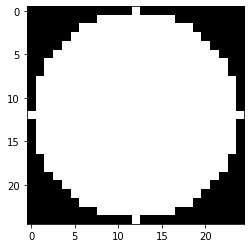

In [10]:
plt.imshow(mask[:, :, 12], cmap='gray')

In [ ]:
# Lesion shapes
# 35, 

In [ ]:
# Insert lesion loop

#train_lesions = np.load("/home/pranjal/VICTRE/victre_breastmass/breastMass/train_lesions.npy")
#train_lesions_array = []

# for name in train_lesions:
#     temp = np.fromfile(name, dtype='uint8')
#     t    = int(name.split("_")[-1].split(".")[0])
#     temp = np.reshape(temp, [t, t, t])
#     train_lesions_array.append(temp)
train_lesions_array = []
train_lesions_array.append(mask)

allfiles = glob.glob("/media/dril/My Passport/CHO-DATA/NO-LESION-MAT/LE/*.mat")
print(len(allfiles))
allfiles.sort()

def insert_lesion(image, z_slice, index):
    coord = []
    count = 0
    #index = random.randint(0, len(train_lesions)-1)
    
    while(count < 4):
        k     = count
        temp  = train_lesions_array[index]
        
        tx    = int(temp.shape[0]/2)
        temp1 = image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx]
        
        temp1[temp == 1] = 0.80
        image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 100-tx:100+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx] = temp1
        
        count = count+1
    
    count = 0
    while(count < 4):
        k     = count
        temp  = train_lesions_array[index]
        
        tx    = int(temp.shape[0]/2)
        temp1 = image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 220-tx:220+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx]
        
        temp1[temp == 1] = 0.80
        image[250+k*100-tx:250+k*100+temp.shape[0]-tx, 220-tx:220+temp.shape[0]-tx, z_slice-tx:z_slice+temp.shape[0]-tx] = temp1
        
        count = count+1
        
    return image

index = 0
for f in allfiles:
    data    = sio.loadmat(f)["head"]
    print(data.shape, f)
    #tx = int(f.split("/")[-1].split("_")[1].split("x")[0])
    #ty = int(f.split("/")[-1].split("_")[1].split("x")[1])
    #tz = int(f.split("/")[-1].split("_")[1].split("x")[2].split(".")[0])
    
    name = f.split("/")[-1]
    
    image = data#.reshape([tz, ty, tx])
#     index = int(name.split("-")[1].split("_")[0])
    #index = index%len(train_lesions)
    
#     #print(name, index)
    
#     #if image.shape[0] < 280:
#     #    image = insert_lesion(image, 130, index)
#     #else:
#     image = data
    image = insert_lesion(image, 160, index)
    #print(image.shape)
    #break
    
    temp = {}
    temp["head"] = np.single(image)
    sio.savemat("/media/dril/My Passport/CHO-DATA/WITH-LESION-MAT/LE/"+name, temp, do_compression=True)
# #     image.tofile("/media/pranjal/BackupPlus/CEDBT/CHO-DATA/WITH-LESION-MAT/"+name)
    

(320, 448, 800)


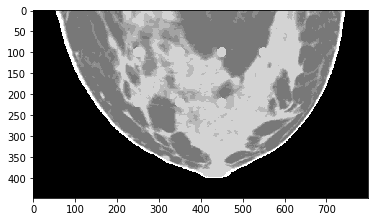

In [69]:
index = 35
a = sio.loadmat("/media/dril/My Passport/CHO-DATA/WITH-LESION-MAT/LE/"+str(index)+".mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
print(testvol.shape)
plt.imshow(testvol[160, :, :], cmap='gray')

In [70]:
#15, 16, 19, 20, 27, 29, 31, 35
#plt.hist(testvol.flatten())
testvol[testvol != 0.80] = 0

In [ ]:

# FOr getting projectons of all duke phantoms
todo = [15, 16, 19, 20, 27, 29, 31, 35]
for i in range(1, 176):
    if i not in todo:
        continue
    
    a = get_duke_proj(i, 1)
    a.astype('float32').tofile("/media/dril/My Passport/CHO-DATA/WITH-LESION-PROJ/LE/proj_"+str(i)+"_3000x1504x25.raw")
    #a = get_duke_proj(i, 0)
    #a.astype('float32').tofile("/media/dril/My Passport/CHO-DATA/NO-LESION-PROJ/LE/proj_"+str(i)+"_3000x1504x25.raw")
    print(i)
    #a, b  = load_prj_duke("left")
#print(a.shape, b.shape)

In [33]:
a = np.fromfile("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR-RANDOM/CE20_2600x1200x48.4_0.0005_-0.0.raw", dtype='float32')
b = np.fromfile("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR-RANDOM/CE20_HE_2600x1200x48.4_0.0005_-0.0.raw", dtype='float32')

print(a.shape, b.shape)
a = np.reshape(a, [48, 1200, 2600])
b = np.reshape(b, [48, 1200, 2600])

c = b-0.37*a
c.astype('float32').tofile("c2_2600x1200x48.raw")

(149760000,) (149760000,)


In [65]:
xi = 0
for i in range(len(x_val_array)):
    if z_val_array[i] <= 0.5:
        xi = xi+1
print(xi)

4380


In [250]:
z_array1     = np.ones(x_array.shape)
z_val_array1 = np.ones(x_val_array.shape)

for i in range(len(z_array1)):
    z_array1[i, :, :, :] = z_array1[i, :, :, :]*z_array[i]
for i in range(len(z_val_array1)):
    z_val_array1[i, :, :, :] = z_val_array1[i, :, :, :]*z_val_array[i]

In [ ]:
# For training the combined Model


model       = unet_two()
checkpoints = ModelCheckpoint('all-data-0-to-7-combined-0.0005-1.h5', 
                                             monitor='val_loss', verbose=0, save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)

z_array1     = np.ones(x_array.shape)
z_val_array1 = np.ones(x_val_array.shape)

for i in range(len(z_array1)):
    z_array1[i, :, :, :] = z_array1[i, :, :, :]*z_array[i]
for i in range(len(z_val_array1)):
    z_val_array1[i, :, :, :] = z_val_array1[i, :, :, :]*z_val_array[i]

model.fit([x_array, z_array1, np.ones(z_array.shape)*0.1, np.ones(z_array.shape)*0.2, np.ones(z_array.shape)*0.3, np.ones(z_array.shape)*0.4, np.ones(z_array.shape)*0.5, np.ones(z_array.shape)*0.6, np.ones(z_array.shape)*0.7], y_array,
          validation_data=([x_val_array, z_val_array1, np.ones(z_val_array.shape)*0.1, np.ones(z_val_array.shape)*0.2, np.ones(z_val_array.shape)*0.3, np.ones(z_val_array.shape)*0.4, np.ones(z_val_array.shape)*0.5, np.ones(z_val_array.shape)*0.6, np.ones(z_val_array.shape)*0.7], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])


In [ ]:
# For drawing the Pictures of all samples together

index      = 0
total_size = 500

z_arr  = []
drawit = []
for i in range(259, 262):#range(index*total_size, total_size*(index+1)):
    print(z_val_array[i, 0])
    if True:#z_val_array[i, 0] < 0.35 and z_val_array[i, 0] > 0.25:
        #print("Adding Image")
        drawit.append(np.concatenate([x_val_array[i, :, :, 0], y_val_array[i, :, :, 0]], axis=-1))
        z_arr.append(z_val_array[i, 0])

drawit = np.array(drawit)
drawit = np.reshape(drawit, [-1, 256])
print(drawit.shape)

plt.figure(figsize=(12800/2000, 256))
plt.imshow(drawit.astype('float32'), cmap='gray')

In [23]:
# print(x_array.shape, y_array.shape, z_array.shape)

# np.save('x_val_array_random2.npy', x_array)
# np.save('y_val_array_random2.npy', y_array)
# np.save('z_val_array_random2.npy', z_array)

In [13]:
# np.save('/media/dril/My Passport/TRAINING-DATA/x_array_random.npy', x_array)
# np.save('/media/dril/My Passport/TRAINING-DATA/y_array_random.npy', y_array)
# np.save('/media/dril/My Passport/TRAINING-DATA/z_array_random.npy', z_array)

In [150]:
# Some garbage code for reading the data

x_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_array.npy')
y_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_array.npy')
z_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_array.npy')

x1 = []
y1 = []
z1 = []

for i in range(7000):
    #if z_array[i, 0] == 0.2 or z_array[i, 0] == 0.4 or z_array[i, 0] == 0.6:#(i+1) % 6 == 0 or i % 6 == 0:
    #    continue
    if z_array[i, 0] != 0.3:
        continue
    else:
        x1.append(x_array[i, :, :, :])
        y1.append(y_array[i, :, :, :])
        z1.append(z_array[i, :])

x1 = np.array(x1)
y1 = np.array(y1)
z1 = np.array(z1)

print(x1.shape, y1.shape, z1.shape)

(1000, 128, 128, 1) (1000, 128, 128, 1) (1000, 1)


In [ ]:
model = unet()
#model.load_weights('all-data-0-to-7-0.0005-5.h5')
checkpoints = ModelCheckpoint('all-data-random2-0-to-5-0.0005-5-more-filters.h5', 
                                              monitor='val_loss', verbose=0, save_best_only=True, 
                                              save_weights_only=False, mode='auto', period=1)

model.fit([x_array, z_array], y_array, 
          validation_data=([x_val_array, z_val_array], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])

In [31]:
# x1_array = np.load('x1_array_random-CE11-2-one-iter.npy')
# x_array = np.load('x_array_random-CE11-2-one-iter.npy')
# y_array = np.load('y_array_random-CE11-2-one-iter.npy')
# z_array = np.load('z_array_random-CE11-2-one-iter.npy')


# print(x_array.shape, y_array.shape, z_array.shape, x1_array.shape)

(2360, 128, 128, 1) (2360, 128, 128, 1) (2360, 1) (2360, 128, 128, 1)


In [60]:
result = model.predict([x_val_array, z_val_array], batch_size=8)
print(result.shape)

(7000, 128, 128, 1)


In [ ]:
index = random.randint(0, len(x_val_array))
print(z_val_array[index])
plt.figure(figsize=(10,5))
plt.imshow(np.concatenate([x_val_array[index, :, :, 0], y_val_array[index, :, :, 0], result[index, :, :, 0]], axis=-1).astype('float32'), cmap='gray')

In [ ]:
# x_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_array_random2.npy')
# y_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_array_random2.npy')
# z_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_array_random2.npy')

# x_val_array = np.load('/media/dril/My Passport/TRAINING-DATA/x_val_array_random2.npy')
# y_val_array = np.load('/media/dril/My Passport/TRAINING-DATA/y_val_array_random2.npy')
# z_val_array = np.load('/media/dril/My Passport/TRAINING-DATA/z_val_array_random2.npy')


model = unet()
#model.load_weights('all-data-random-0-to-7-0.0005-2.h5')
checkpoints = ModelCheckpoint('all-data-0-to-7-0.0005-5.h5', 
                                              monitor='val_loss', verbose=0, save_best_only=True, 
                                              save_weights_only=False, mode='auto', period=1)

model.fit([x_array, z_array], y_array, 
          validation_data=([x_val_array, z_val_array], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])

In [144]:
#model = load_model('all-data-only-7-0.0005-1.h5', compile='False')
#model = load_model('all-data-only-3-0.0005-1.h5', compile='False')

#model = load_model('all-data-0-to-7-0.0005-1.h5', compile='False')
result_train = model.predict([x_val_array, z_val_array], batch_size=8)
#result_train1 = model.predict(x1, batch_size=8)
print(result_train.shape)

(525, 128, 128, 1)


In [20]:
# Check the loss values

check_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

r2 = []
y2 = []
for i in range(int(len(x1)*0.7)):
    r2.append(result_train[i])
    y2.append(y1[i])
train_loss = np.mean(np.abs(np.array(r2)-np.array(y2)))

r2= []
y2 = []
for i in range(int(len(x1)*0.7), len(x1)):
    r2.append(result_train[i])
    y2.append(y1[i])
test_loss = np.mean(np.abs(np.array(r2)-np.array(y2)))
    
print("Train Loss", train_loss)
print("Test Loss", test_loss)
print("**********************************")

Train Loss 0.00031360463
Test Loss 0.00057295326
**********************************


In [ ]:
# Check the loss values


check_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for k in range(7):
    check_val = check_values[k]

    r1 = []
    y1 = []
    for i in range(int(len(x_array)*0.7)):
        if z_array[i, 0] == check_val:
            r1.append(result_train[i])
            y1.append(y_array[i])
    train_loss = np.mean(np.abs(np.array(r1)-np.array(y1)))

    r1 = []
    y1 = []
    for i in range(int(len(x_array)*0.7), len(x_array)):
        if z_array[i, 0] == check_val:
            r1.append(result_train[i])
            y1.append(y_array[i])
    test_loss = np.mean(np.abs(np.array(r1)-np.array(y1)))
    
    print("Check value ", check_values[k])
    print("Train Loss", train_loss)
    print("Test Loss", test_loss)
    print("**********************************")

In [ ]:
# Some signal calculation Code

.randint(int(len(x1)*0.1), int(len(x1)*0.4))
print(index)
print(z_array[index])
plt.figure(figsize=(10,5))

#print(np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])), np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])))
#print(np.mean(np.abs(result_train1[index, :, :, 0]-result_train[index, :, :, 0])), np.mean(np.abs(result_train1[index, :, :, 0]-y1[index, :, :, 0])), np.mean(np.abs(y1[index, :, :, 0]-result_train[index, :, :, 0])))


#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()),  ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

y1 = y_val_array
x1 = x_val_array

#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

index = 261#index = random.randint(int(len(x_array)*0.8), len(x_array)-1)
index = random.randint(0, len(x_val_array)-1)
#index = random.randint(int(len(x1)*0.1), int(len(x1)*0.4))
print(index)
print(z_array[index])
plt.figure(figsize=(10,5))

#print(np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])), np.mean(np.abs(result_train[index, :, :, 0], y_array[index, :, :, 0])))
#print(np.mean(np.abs(result_train1[index, :, :, 0]-result_train[index, :, :, 0])), np.mean(np.abs(result_train1[index, :, :, 0]-y1[index, :, :, 0])), np.mean(np.abs(y1[index, :, :, 0]-result_train[index, :, :, 0])))


#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()),  ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

y1 = y_val_array
x1 = x_val_array

#print(ssim(result_train[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))

#index = 253
def signaltonoise(a, axis=0, ddof=0):
    a  = np.asanyarray(a)
    m  = np.mean(a)#a.mean(axis)
    sd = np.std(a) #a.std(axis=axis, ddof=ddof)
    return m/sd#np.where(sd == 0, 0, m/sd)

print(ssim(x1[index, :, :, 0], y1[index, :, :, 0], dynamic_range=y1[index, :, :, 0].max() - y1[index, :, :, 0].min()))
print(signaltonoise(result_train[index, :, :, 0]), signaltonoise(x1[index, :, :, 0]), signaltonoise(y1[index, :, :, 0]))
print(haar_psi(result_train[index, :, :, 0], y1[index, :, :, 0], preprocess_with_subsampling = True)[0], haar_psi(x1[index, :, :, 0], y1[index, :, :, 0], preprocess_with_subsampling = True)[0])
print(np.mean(np.abs(result_train[index, :, :, 0] - y1[index, :, :, 0])), np.mean(np.abs(x1[index, :, :, 0] - y1[index, :, :, 0])))

print(np.mean(np.abs(result_train[index, :, :, 0] - y_val_array[index, :, :, 0])), np.mean(np.abs(x_val_array[index, :, :, 0] - y_val_array[index, :, :, 0])))

#plt.imshow(np.concatenate([x1[index, :, :, 0], result_train[index, :, :, 0], result_train1[index, :, :, 0], y1[index, :, :, 0]], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([x_array[index, :, :, 0], result_train[index, :, :, 0], y_array[index, :, :, 0]], axis=-1), cmap='gray')
plt.imshow(np.concatenate([x_val_array[index, :, :, 0].astype('float32'),  result_train[index, :, :, 0], y_val_array[index, :, :, 0].astype('float32')], axis=-1), cmap='gray')
#plt.imshow(np.concatenate([x_val_array[index, :, :, 0].astype('float32'), result_train[index, :, :, 0].astype('float32'), y_val_array[index, :, :, 0].astype('float32')], axis=-1), cmap='gray')

In [112]:
print(signaltonoise(result_train[index, :, :, 0]), signaltonoise(x1[index, :, :, 0]), signaltonoise(y1[index, :, :, 0]))


70.963104 20.62 20.62


In [110]:
print(np.mean(np.abs(result_train[index, :, :, 0] - y1[index, :, :, 0])), np.mean(np.abs(x1[index, :, :, 0] - y1[index, :, :, 0])))

0.0027201339 0.0


In [ ]:
# Reading the Training Data for Baseline U-Net Model

s = 7800

p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*.4_"+str(0.0005)+"*.raw")#+str(0.1)+"'".raw')
print(p)

x = np.fromfile(p[-1], dtype='float32')
x = np.reshape(x, [48, 1200, 2600])

y1 = np.fromfile(p[0], dtype='float32')
y1 = np.reshape(y1, [48, 1200, 2600])

y2 = np.fromfile(p[1], dtype='float32')
y2 = np.reshape(y2, [48, 1200, 2600])

y3 = np.fromfile(p[2], dtype='float32')
y3 = np.reshape(y3, [48, 1200, 2600])

y4 = np.fromfile(p[3], dtype='float32')
y4 = np.reshape(y4, [48, 1200, 2600])

y5 = np.fromfile(p[4], dtype='float32')
y5 = np.reshape(y5, [48, 1200, 2600])

y6 = np.fromfile(p[5], dtype='float32')
y6 = np.reshape(y6, [48, 1200, 2600])

#y7 = np.fromfile(p[6], dtype='float32')
#y7 = np.reshape(y7, [48, 1200, 2600])


x_array = []
y_array = []
z_array = []

print("Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 48)
    
    tempx = x[iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    for j in range(6):
        x_array.append(tempx)
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    #tempy = y7[iz, ix:ix+128, iy:iy+128]
    #y_array.append(tempy)
    
    z_array.append(0.1)
    z_array.append(0.2)
    z_array.append(0.3)
    z_array.append(0.4)
    z_array.append(0.5)
    z_array.append(0.7)
    
    if len(x_array) == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = np.array(x_array)[perm]
# y_array = np.array(y_array)[perm]
# z_array = np.array(z_array)[perm]

x_array = np.expand_dims(x_array, axis=-1)
y_array = np.expand_dims(y_array, axis=-1)
z_array = np.expand_dims(z_array, axis=-1)


print(x_array.shape, y_array.shape, z_array.shape)

In [24]:
# Some Garbage Reading Code

s = 7800


x_array = []
y_array = []
z_array = []

print("Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 48)
    
    tempx = x[iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    for j in range(6):
        x_array.append(tempx)
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array.append(tempy)
    #tempy = y7[iz, ix:ix+128, iy:iy+128]
    #y_array.append(tempy)
    
    z_array.append(0.1)
    z_array.append(0.2)
    z_array.append(0.3)
    z_array.append(0.4)
    z_array.append(0.5)
    z_array.append(0.7)
    
    if len(x_array) == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = np.array(x_array)[perm]
# y_array = np.array(y_array)[perm]
# z_array = np.array(z_array)[perm]

x_array = np.expand_dims(x_array, axis=-1)
y_array = np.expand_dims(y_array, axis=-1)
z_array = np.expand_dims(z_array, axis=-1)


print(x_array.shape, y_array.shape, z_array.shape)


Reading Done
(7800, 128, 128, 1) (7800, 128, 128, 1) (7800, 1)


In [ ]:
# For reading the Data

input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")#+str(0.1)+"'".raw')
for t in input_p:
    print(t)
print("*********************")
output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")
#output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1

output_p = output_p_new
print("Length of output_p is ", len(output_p))

In [ ]:
#  Reading the Training Data for U-net Model Single parameter 

s = 7200

x_array = np.zeros([s, 128, 128, 5], dtype='float16')
y_array = np.zeros([s, 128, 128, 1], dtype='float16')
z_array = np.zeros([s, 1], dtype='float16')

# x       = []
# input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")
# input_p.sort()
# for p in input_p:
#     temp = np.fromfile(p, dtype='float32')
#     temp = np.reshape(temp, [48, 1200, 2600])
#     x.append(temp)

# output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")
# for p in output_p:
#     print(p)

y1 = np.fromfile(output_p[0], dtype='float32')
y1 = np.reshape(y1, [48, 1200, 2600])

y2 = np.fromfile(output_p[1], dtype='float32')
y2 = np.reshape(y2, [48, 1200, 2600])

y3 = np.fromfile(output_p[2], dtype='float32')
y3 = np.reshape(y3, [48, 1200, 2600])

y4 = np.fromfile(output_p[3], dtype='float32')
y4 = np.reshape(y4, [48, 1200, 2600])

y5 = np.fromfile(output_p[4], dtype='float32')
y5 = np.reshape(y5, [48, 1200, 2600])

y6 = np.fromfile(output_p[5], dtype='float32')
y6 = np.reshape(y6, [48, 1200, 2600])

#x_array = []
#y_array = []
#z_array = []

counter   = 0
counter_x = 0

print("File Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 40)
    
    tempx = x[0][iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    tempy = y1[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y2[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y3[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y5[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    tempy = y6[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    
    
    reg_value = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    for j in range(len(reg_value)):
        temp1 = []
        temp2 = []
        for k in range(5):
            x_array[counter_x, :, :, k] = x[k][iz, ix:ix+128, iy:iy+128]
            #temp1.append(x[k][iz, ix:ix+128, iy:iy+128])
            #temp2.append(np.ones(tempy.shape)*reg_value[j])
        #x_array[counter_x, :, :, :, 1] = temp2
        z_array[counter_x, 0] = reg_value[j]
        counter_x = counter_x+1
    print(counter_x)
    #z_array.append(*0.1)
    #z_array.append(np.ones(tempy.shape)*0.3)
    #z_array.append(np.ones(tempy.shape)*0.5)
    #z_array.append(np.ones(tempy.shape)*0.7)
    
    if counter_x == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = x_array[perm]
# y_array = y_array[perm]
# z_array = np.array(z_array)[perm]

#x_array = np.expand_dims(x_array, axis=-1)
#y_array = np.expand_dims(y_array, axis=-1)
#z_array = np.expand_dims(z_array, axis=-1)

#print(x_array.shape, y_array.shape, z_array.shape)
print(x_array.shape, y_array.shape, z_array.shape)

In [ ]:
#  Reading the Training Data for U-net Model Double parameter 

s = 4800*10

x_array = np.zeros([s, 128, 128, 5], dtype='float16')
y_array = np.zeros([s, 128, 128, 1], dtype='float16')
z1_array = np.zeros([s, 1], dtype='float16')
z2_array = np.zeros([s, 1], dtype='float16')

# x       = []
# input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")
# input_p.sort()
# for p in input_p:
#     temp = np.fromfile(p, dtype='float32')
#     temp = temp.astype('float16')
#     temp = np.reshape(temp, [48, 1200, 2600])
#     #print(p)
#     x.append(temp)

y_raw_array = []
output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p:
    print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array.append(temp_y)

counter   = 0
counter_x = 0

print("File Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 40)
    
    tempx = x[0][iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
    #arr1 = [0.0001, 0.0002, 0.0003, 0.0005, 0.0006, 0.0007, 0.001]
    #arr2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    
    arr1 = [0.0002, 0.0005, 0.0007, 0.001]
    arr2 = [0.1,  0.3,  0.5, 0.7]
    #arr2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
    
    
    counter_raw = 0
    for t1 in arr1:
        for t2 in arr2:
            tempy = y_raw_array[counter_raw][iz, ix:ix+128, iy:iy+128]
            y_array[counter, :, :, 0] = tempy
            
            z1_array[counter, 0] = t1
            z2_array[counter, 0] = t2
            
            for k in range(5):
                x_array[counter, :, :, k] = x[k][iz, ix:ix+128, iy:iy+128]
        
            counter_raw = counter_raw+1
            counter     = counter+1
    #print(counter)
    if counter == s:
        break

# perm    = np.random.permutation(len(x_array))
# x_array = x_array[perm]
# y_array = y_array[perm]
# z1_array = np.array(z1_array)[perm]
# z2_array = np.array(z2_array)[perm]

#x_array = np.expand_dims(x_array, axis=-1)
#y_array = np.expand_dims(y_array, axis=-1)
#z_array = np.expand_dims(z_array, axis=-1)

#print(x_array.shape, y_array.shape, z_array.shape)
print(x_array.shape, y_array.shape, z1_array.shape, z2_array.shape)

In [162]:
allp = glob.glob('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*0.0005*')
new_allp = []
new_allp.append(allp[-1]) # Un-regularized SART
new_allp.append(allp[0])
new_allp.append(allp[2])
new_allp.append(allp[4])

allp = new_allp
print(allp)

['/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_0.raw', '/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.1.raw', '/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.3.raw', '/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27_2600x1200x48.4_0.0005_-0.5.raw']


In [164]:
model = load_model('/media/dril/Windows/newrecon2/newrecon/condition1.h5')

In [224]:
#  Reading the Training Data for U-net Model No parameter

s = 2000

x_array = np.zeros([s, 128, 128, 5], dtype='float16')
y_array = np.zeros([s, 128, 128, 1], dtype='float16')
#z_array = np.zeros([s, 1], dtype='float16')

x       = []
input_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*"+str(0.0005)+"*_0.raw")
for p in input_p:
    temp = np.fromfile(p, dtype='float32')
    temp = np.reshape(temp, [48, 1200, 2600])
    x.append(temp)

output_p = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18*4_"+str(0.0005)+"*.raw")

# y1 = np.fromfile(output_p[0], dtype='float32')
# y1 = np.reshape(y1, [48, 1200, 2600])

#y2 = np.fromfile(output_p[1], dtype='float32')
#y2 = np.reshape(y2, [48, 1200, 2600])

#y3 = np.fromfile(output_p[2], dtype='float32')
#y3 = np.reshape(y3, [48, 1200, 2600])

y4 = np.fromfile(output_p[3], dtype='float32')
y4 = np.reshape(y4, [48, 1200, 2600])


#x_array = []
#y_array = []
#z_array = []

counter   = 0
counter_x = 0

print("File Reading Done")

while(True):
    ix = np.random.randint(128, 1200-128)
    iy = np.random.randint(128, 1200-128)
    iz = np.random.randint(25, 40)
    
    tempx = x[0][iz, ix:ix+128, iy:iy+128]
    
    if np.count_nonzero(tempx.flatten())*1.0/(128*128) < 0.9:
        continue
    
#     tempy = y1[iz, ix:ix+128, iy:iy+128]
#     y_array[counter, :, :, 0] = tempy
#     counter = counter+1
    #y_array.append(tempy)
#     tempy = y2[iz, ix:ix+128, iy:iy+128]
#     y_array[counter, :, :, 0] = tempy
#     counter = counter+1
    #y_array.append(tempy)
#    tempy = y3[iz, ix:ix+128, iy:iy+128]
#    y_array[counter, :, :, 0] = tempy
#    counter = counter+1
#     #y_array.append(tempy)
    tempy = y4[iz, ix:ix+128, iy:iy+128]
    y_array[counter, :, :, 0] = tempy
    counter = counter+1
    #y_array.append(tempy)
    
    
    reg_value = [0.7]#[0.1, 0.3, 0.5, 0.7]
    for j in range(1):
        temp1 = []
        temp2 = []
        for k in range(5):
            x_array[counter_x, :, :, k] = x[k][iz, ix:ix+128, iy:iy+128]
            #temp1.append(x[k][iz, ix:ix+128, iy:iy+128])
            #temp2.append(np.ones(tempy.shape)*reg_value[j])
        #x_array[counter_x, :, :, :, 1] = temp2
        #z_array[counter_x, 0] = reg_value[j]
        counter_x = counter_x+1
    #z_array.append(*0.1)
    #z_array.append(np.ones(tempy.shape)*0.3)
    #z_array.append(np.ones(tempy.shape)*0.5)
    #z_array.append(np.ones(tempy.shape)*0.7)
    
    if counter_x == s:
        break

perm    = np.random.permutation(len(x_array))
x_array = x_array[perm]
y_array = y_array[perm]
z_array = np.array(z_array)[perm]

#x_array = np.expand_dims(x_array, axis=-1)
#y_array = np.expand_dims(y_array, axis=-1)
#z_array = np.expand_dims(z_array, axis=-1)

#print(x_array.shape, y_array.shape, z_array.shape)
print(x_array.shape, y_array.shape, z_array.shape)

File Reading Done
(2000, 128, 128, 5) (2000, 128, 128, 1) (2000, 1)


In [21]:
print(x_array.shape, y_array.shape, z_array.shape)
#plt.imshow(np.concatenate([x_array[100, :, :, 0], y_array[100, :, :, 0]], axis=-1), cmap='gray')

(9100, 128, 128, 1) (9100, 128, 128, 1) (7800, 1)


In [ ]:
model = unet()
model.fit([x_array, z_array], y_array, validation_split=0.2, batch_size=8, epochs=10000)

In [ ]:
model = load_model('/media/dril/Windows/newrecon2/newrecon/condition4-0.5.h5')
#print(model.summary())

In [57]:
model.save("condition-all-2-both-parameters.h5")
#model.save("condition1.h5")

In [26]:
result_single = model.predict([x_array, z_array], batch_size=16)
#result1 = model.predict([x_array, z_array+2], batch_size=16)
#result2 = model.predict([x_array, z_array+1], batch_size=16)
#result3 = model.predict([x_array, z_array+1.5], batch_size=16)

In [ ]:
# Training the Deep Model

beta_array = [0.1, 0.3, 0.5, 0.7]

for beta in beta_array:
    
a = np.fromfile('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18_2600x1200x48.4_0.0005_-0.5.raw', dtype='float32')
a = np.reshape(a, [ 48, 1200, 2600])
b = np.fromfile('/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE18_2600x1200x48.4_0.0005_0.raw', dtype='float32')
b = np.reshape(b, [ 48, 1200, 2600])

print(a.shape)

In [8]:
a = np.fromfile("/media/dril/My Passport/CHO-VOL-LESION/35_lesion_2200x1200x48.4_0.0005_-0.185.raw", dtype="float32")
a = np.reshape(a, [48, 1200, 2200])
print(a.shape)

(48, 1200, 2200)


In [81]:
# For creating signal present and absent training data pairs

allfiles = glob.glob("/media/dril/My Passport/CHO-VOL-LESION/*.raw.npy")
allfiles.sort()

print(len(allfiles))

todo = [15, 16, 19, 20, 27, 29, 31, 35]

def extract_2d_patches(a):
    patches = []
    sx = 789
    sy = 1453
    ts = 128
    
    for i in range(4):
        temp = a[28, sx-ts:sx+ts, sy-ts:sy+ts]
        sy   = sy-235
        #print(temp.shape)
        patches.append(temp)
    
    sx = 503
    sy = 1453
    for i in range(4):
        temp = a[25, sx-ts:sx+ts, sy-ts:sy+ts]
        sy   = sy-235
        #print(temp.shape)
        patches.append(temp)
    
    return np.array(patches)

all_patches = []

for f in allfiles:
    if int(f.split("/")[-1].split("_")[0]) not in todo:
        continue
    print(f.split("/")[-1])
    
    a = np.load(f)
    #a = np.reshape(a, [48, 1200, 2200])
    #np.save(f, a.astype('float16'))
    patches = extract_2d_patches(a)
    for k in range(8):
        all_patches.append(patches[k])
    #break
all_patches1 = np.array(all_patches)

#np.save('all_patches_lesion.npy', all_patches)
print(all_patches1.shape)

allfiles = glob.glob("/media/dril/My Passport/CHO-VOL/*.raw.npy")
allfiles.sort()

all_patches = []
for f in allfiles:
    if int(f.split("/")[-1].split("_")[0]) not in todo:
        continue
    
    print(f.split("/")[-1])
    a = np.load(f)
    #a = np.reshape(a, [48, 1200, 2200])
    #np.save(f, a.astype('float16'))
    patches = extract_2d_patches(a)
    for k in range(8):
        all_patches.append(patches[k])
    #all_patches.append(patches)
all_patches = np.array(all_patches)

#np.save('all_patches_without_lesion.npy', all_patches)
print(all_patches.shape)

48
15_lesion_2200x1200x48.4_0.0005_-0.012.raw.npy
15_lesion_2200x1200x48.4_0.0005_-0.047.raw.npy
15_lesion_2200x1200x48.4_0.0005_-0.195.raw.npy
15_lesion_2200x1200x48.4_0.0005_-0.244.raw.npy
15_lesion_2200x1200x48.4_0.0005_-0.314.raw.npy
15_lesion_2200x1200x48.4_0.0005_-0.369.raw.npy
16_lesion_2200x1200x48.4_0.0005_-0.205.raw.npy
16_lesion_2200x1200x48.4_0.0005_-0.282.raw.npy
16_lesion_2200x1200x48.4_0.0005_-0.311.raw.npy
16_lesion_2200x1200x48.4_0.0005_-0.337.raw.npy
16_lesion_2200x1200x48.4_0.0005_-0.403.raw.npy
16_lesion_2200x1200x48.4_0.0005_-0.512.raw.npy
19_lesion_2200x1200x48.4_0.0005_-0.049.raw.npy
19_lesion_2200x1200x48.4_0.0005_-0.086.raw.npy
19_lesion_2200x1200x48.4_0.0005_-0.133.raw.npy
19_lesion_2200x1200x48.4_0.0005_-0.136.raw.npy
19_lesion_2200x1200x48.4_0.0005_-0.167.raw.npy
19_lesion_2200x1200x48.4_0.0005_-0.393.raw.npy
20_lesion_2200x1200x48.4_0.0005_-0.055.raw.npy
20_lesion_2200x1200x48.4_0.0005_-0.22.raw.npy
20_lesion_2200x1200x48.4_0.0005_-0.298.raw.npy
20_lesion_2

In [82]:
a1 = all_patches1#np.reshape(all_patches1, [48*8, 256, 256])
a2 = all_patches#np.reshape(all_patches, [48*8, 256, 256])

a1 = np.moveaxis(a1, 0, -1)
a2 = np.moveaxis(a2, 0, -1)

print(a1.shape, a2.shape)
#sio.savemat("lesions.mat")

(256, 256, 384) (256, 256, 384)


In [83]:
h2 = {}
h2["sproi"] = a1
sio.savemat("lesions.mat", h2)

h1 = {}
h1["saroi"] = a2
sio.savemat("nolesions.mat", h1)

In [27]:
np.save("all_patches_lesion-new.npy", all_patches1)
np.save("all_patches_without_lesion-new.npy", all_patches)

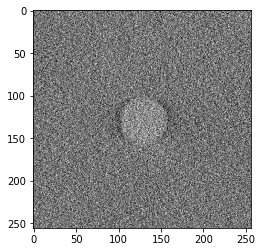

In [66]:
index  = random.randint(0, 7)
index1 = random.randint(0, len(all_patches)-1)
plt.imshow(all_patches1[index1, index, :, :], cmap='gray')

In [ ]:
# Output image patches

y_raw_array = []
output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*4_*.raw")
output_p.sort()
output_p_new = []
counter      = 0
for t in output_p:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p:
    #print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array.append(temp_y)

In [ ]:
# Input Image patches

arr1 = [0.0002, 0.0005, 0.0007, 0.001]
arr2 = [0.1,  0.3,  0.5, 0.7]

output_p_new1 = []

for a1 in arr1:
    for a2 in arr2:
        y_raw_array = []
        output_p    = glob.glob("/media/dril/My Passport/DBT-HUBER-VOL-DEBLUR/CE27*"+str(a1)+"*"+str(a2)+".raw")
        output_p.sort()
        counter      = 0
        for f in output_p:
            #print(f)
            output_p_new1.append(f)
        print("*************************")

output_p_new = []
counter      = 0
for t in output_p_new1:
    if '_0.raw' not in t and '.0003' not in t and '.0001' not in t and '.0006' not in t and '0.2' not in t and '0.4' not in t:
        print(counter, t)
        output_p_new.append(t)
        counter = counter+1
output_p = output_p_new

for p in output_p_new:
    print(p)

In [ ]:
y_raw_array1 = []

for p in output_p_new:
    print(p)
    temp_y = np.fromfile(p, dtype='float32')
    temp_y = temp_y.astype('float16')
    temp_y = np.reshape(temp_y, [48, 1200, 2600])
    y_raw_array1.append(temp_y)

(16, 128, 128, 1) (16, 128, 128, 5) (16, 1) (16, 1)


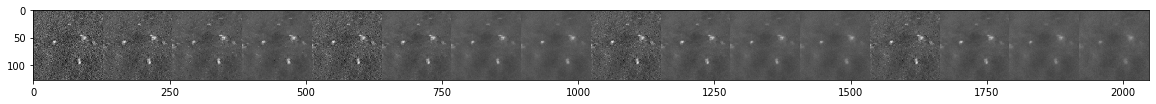

In [26]:
arr1 = [0.0002, 0.0005, 0.0007, 0.001]
arr2 = [0.1,  0.3,  0.5, 0.7]

all_results =  []
all_results_x =  []
index       = 0

z1_array = []
z2_array = []

for a1 in arr1:
    for a2 in arr2:
        temp_x = np.zeros([128, 128, 5])
        for k in range(5):
            temp_y = y_raw_array1[index*5+k]
            temp   = temp_y[24, 700+128:700+128*2, 1870+128:1870+128*2].astype('float32')
            temp_x[:, :, k] = temp
        all_results_x.append(temp_x)
        
        temp_y = y_raw_array[index]
        temp   = temp_y[24, 700+128:700+128*2, 1870+128:1870+128*2].astype('float32')
        all_results.append(temp)
        index = index+1
        
        z1_array.append(a1)
        z2_array.append(a2)
    
#for p in range(len(y_raw_array)):
#    #temp_y = np.fromfile(p, dtype='float32')
#    #temp_y = temp_y.astype('float16')
#    #temp_y = np.reshape(temp_y, [48, 1200, 2600])
    

plt.figure(figsize=(20,10))
plt.imshow(np.concatenate(all_results, axis=-1), cmap='gray')

all_results_x = np.array(all_results_x)
all_results   = np.array(all_results)


all_results = np.expand_dims(all_results, axis=-1)
z1_array    = np.expand_dims(z1_array, axis=-1)
z2_array    = np.expand_dims(z2_array, axis=-1)

print(all_results.shape, all_results_x.shape, z1_array.shape, z2_array.shape)

In [ ]:
model = load_model("/media/dril/Windows/newrecon2/newrecon/condition-all-2-both-parameters.h5")
print(model.summary())

In [6]:
z1_array = np.load('z1_array.npy')
z2_array = np.load('z2_array.npy')
all_results_x = np.load('all_results_x.npy')

In [31]:
np.save('all_results_x.npy', all_results_x)
np.save('z1_array.npy', z1_array)
np.save('z2_array.npy', z2_array)

In [7]:
result  = model.predict([all_results_x, z1_array*1000, z2_array], batch_size=8)
print(result.shape)

(16, 128, 128, 1)


In [7]:
print(host_prj_allangle.shape)
#plt.figure(figsize=(20,10))
#plt.imshow(np.concatenate(result[:, :, :, 0], axis=0).T, cmap='gray')

(143360000,)


In [ ]:
# Lesion Location Information Array
1  1692, 1034, 34
3  2043, 280,  18
3  2124, 1146, 17
3  1272, 236,  32
6  1293, 440,  16
7  1708, 496,  44
7  941, 1100,  13
10 874, 1018,  28
10 1922, 734,  33 
10 1957, 413,  38
10 2018, 556,  37
10 1961, 470,  7
11 1298, 661,  22
13 1628, 348,  34
13 1797, 854,  34
13 1622, 349,  34
13 1596, 510,  31
13 1550, 669,  37
19 686, 1125, 20
21 732, 464,  9
25 1985, 576,  64
25 1440, 256,  57
25 1864, 1040, 36
27 1429. 925,  64
27 1278, 829,  64
29 1246, 977,  21
29 1380, 905,  19
33 1104, 666,  24
35 1670, 725,  17
37 1128, 877,  56
41 1084, 934,  42
44 1480, 970,  19
45 1638, 610,  47
47 1062, 646,  23
47 1301, 564,  23
47 1870, 625,  23
54 706, 1162,  27
59 841, 1038,  32
60 554, 553,   28
60 468, 830,   22
64 1948, 854,  22
65 1820, 600,  25
66 1510, 328,  40
66 1328, 1001, 20
66 1950, 630,  46
66 1544, 529,  37
67 1672, 542,  42
67 2138, 612,  36
67 1797, 694,  35
67 1164, 737,  33
70 1341, 762, 10
71 1433, 769, 14 
74 2302, 457, 28 
75 2107, 777, 40

In [136]:
# Lesion Location information Array

h = {}
s = open("/home/dril/lesion_array", "r").read()
s = s.split("\n")
s = s[:-1]
count = 0
for t in s:
    #print(t, "p")
    a = t.strip().split()
    #print(a[0], " p ", a[1], a[2], a[3])
    i = int(a[0])
    x = int(a[1].replace(",", ""))
    y = int(a[2].replace(",", ""))
    z = int(a[3].replace(",", ""))
    #print(i, x, y, z)
    h[count] = [i, x, y, z]
    count = count+1
np.save('lesion_array_hash.npy', h)

In [138]:
print(h, len(h.keys()))

{0: [1, 1692, 1034, 34], 1: [3, 2043, 280, 18], 2: [3, 2124, 1146, 17], 3: [3, 1272, 236, 32], 4: [6, 1293, 440, 16], 5: [7, 1708, 496, 44], 6: [7, 941, 1100, 13], 7: [10, 874, 1018, 28], 8: [10, 1922, 734, 33], 9: [10, 1957, 413, 38], 10: [10, 2018, 556, 37], 11: [10, 1961, 470, 7], 12: [11, 1298, 661, 22], 13: [13, 1628, 348, 34], 14: [13, 1797, 854, 34], 15: [13, 1622, 349, 34], 16: [13, 1596, 510, 31], 17: [13, 1550, 669, 37], 18: [19, 686, 1125, 20], 19: [21, 732, 464, 9], 20: [25, 1985, 576, 64], 21: [25, 1440, 256, 57], 22: [25, 1864, 1040, 36], 23: [27, 1429, 925, 64], 24: [27, 1278, 829, 64], 25: [29, 1246, 977, 21], 26: [29, 1380, 905, 19], 27: [33, 1104, 666, 24], 28: [35, 1670, 725, 17], 29: [37, 1128, 877, 56], 30: [41, 1084, 934, 42], 31: [44, 1480, 970, 19], 32: [45, 1638, 610, 47], 33: [47, 1062, 646, 23], 34: [47, 1301, 564, 23], 35: [47, 1870, 625, 23], 36: [54, 706, 1162, 27], 37: [59, 841, 1038, 32], 38: [60, 554, 553, 28], 39: [60, 468, 830, 22], 40: [64, 1948, 854

In [ ]:
# Getting patches for each lesion

patches = {}
values  = {}

for k in h:
    print(k)
    if k < 18:
        continue
    
    if h[k][0] == 27:
        continue
    
    patches = []
    values  = []
    
    path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
    vol  = np.fromfile(path, dtype="float32")
    vol  = np.reshape(vol, [64, 1200, 3000])
    patches.append(vol[h[k][3]-2:h[k][3]+2, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128])
    values.append(0)
    
    allpaths  = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw.npy")
    for t in allpaths:
        s = float(t.split("/")[-1].split("_")[-2])
        values.append(s)
        print(t, s)
        
        vol  = np.load(t)
        vol  = np.reshape(vol, [64, 1200, 3000])
        temp = vol[h[k][3]-2:h[k][3]+2, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
        print(temp.shape, h[k][2])
        patches.append(temp)
    
    #print()
    a = np.array(patches)
    b = np.array(values)
    print("Length is ", len(values), a.shape)
    np.save("dbt_real_patches_"+str(k)+".npy",       a)
    np.save("dbt_real_patches_values_"+str(k)+".npy", b)
    #for 
    #break
    #print(vol.shape)
    #print(path)

In [322]:
a = np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/reorder-b-0.npy")
b = np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/values-b-0.npy")
print(a)
print(b)

[-0.013 -0.584 -0.093 -0.199  0.    -0.299 -0.466 -0.572 -0.38 ]
[0. 0. 0. 5. 0. 4. 2. 1. 0.]


In [328]:
k = 0
values_stored = np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/values-b-"+str(k)+".npy")
print(values_stored)

[0. 0. 0. 5. 0. 4. 2. 1. 0.]


In [ ]:
# Getting patches for each lesion for training the calibaration CNN

allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/index-b-*.npy")
allindex = []
for f in allfiles:
    index = int(f.split("/")[-1].split("-")[-1][:-4])
    #print(f, index)
    allindex.append(index)

patches = {}
values  = {}



for k in allindex:
    #if h[k][0] not in allindex:
    #    continue
    x = []
    y = []
    
    patches = []
    values  = []
    
    path = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw")[0]
    #vol  = np.fromfile(path, dtype="float32")
    #vol  = np.reshape(vol, [64, 1200, 3000])
    
    dx_array = [-2, 2, -3, 3, -5, 5]
    dy_array = [-2, 2, -3, 3, -5, 5]
    
#     x.append(vol[h[k][3]:h[k][3], h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128])
#     for dx in dx_array:
#         for dy in dy_array:
#             x.append(vol[h[k][3]:h[k][3], h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy])
    
    values_stored  = list(np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/reorder-b-"+str(k)+".npy"))
    ratings_stored = list(np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_annotation/values-b-"+str(k)+".npy"))
    
    print(values_stored)
    print(ratings_stored)
    
    allpaths  = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(h[k][0])+".raw.npy")
    for t in allpaths:
        s = float(t.split("/")[-1].split("_")[-2])
        values.append(s)
        current_rating = ratings_stored[values_stored.index(s)]
        print(t, s)
        
        if current_rating < 1:
            continue
        
        vol  = np.load(t)
        vol  = np.reshape(vol, [64, 1200, 3000])
        
        x.append(vol[h[k][3]:h[k][3], h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128])
        y.append(current_rating)
        
        for dx in dx_array:
            for dy in dy_array:
                x.append(vol[h[k][3]:h[k][3], h[k][2]-128+dx:h[k][2]+128+dx, h[k][1]-128+dy:h[k][1]+128+dy])
                y.append(current_rating)
        
        print(len(x), len(y), current_rating, k)
        
    x = np.array(x)
    y = np.array(y)

    np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/x_"+str(k)+".npy", x)
    np.save("/media/dril/Windows/newrecon2/newrecon/dbt_real_ratings/y_"+str(k)+".npy", y)
        
        #temp = vol[h[k][3]-2:h[k][3]+2, h[k][2]-128:h[k][2]+128, h[k][1]-128:h[k][1]+128]
        #print(temp.shape, h[k][2])
        #patches.append(temp)

[-0.013, -0.584, -0.093, -0.199, 0.0, -0.299, -0.466, -0.572, -0.38]
[0.0, 0.0, 0.0, 5.0, 0.0, 4.0, 2.0, 1.0, 0.0]
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.013_1.raw.npy -0.013
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.093_1.raw.npy -0.093
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.199_1.raw.npy -0.199
37 37 5.0 0
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.299_1.raw.npy -0.299
74 74 4.0 0
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.38_1.raw.npy -0.38
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.466_1.raw.npy -0.466
111 111 2.0 0
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-40-LE-R-CC_3000x1200x64.4_0.0005_-0.572_1.raw.npy -0.572
148 148 1.0 0
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS

148 148 1.0 15
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.433_13.raw.npy -0.433
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.586_13.raw.npy -0.586
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.228_13.raw.npy -0.228
185 185 3.0 15
[-0.586, -0.335, -0.132, 0.0, -0.36, -0.215, -0.356, -0.228, -0.433]
[0.0, 3.0, 0.0, 0.0, 2.0, 4.0, 1.0, 5.0, 0.0]
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.132_13.raw.npy -0.132
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.215_13.raw.npy -0.215
37 37 4.0 16
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.335_13.raw.npy -0.335
74 74 3.0 16
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-08-LE-L-CC_3000x1200x64.4_0.0005_-0.356_13.raw.npy -0.356
111 111 1.0 16
/media/dril/My Passport

111 111 2.0 27
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-L-CC_3000x1200x64.4_0.0005_-0.609_33.raw.npy -0.609
148 148 1.0 27
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-L-CC_3000x1200x64.4_0.0005_-0.144_33.raw.npy -0.144
185 185 4.0 27
[-0.16, -0.408, -0.425, -0.124, -0.437, -0.325, 0.0, -0.121, -0.28]
[2.0, 0.0, 1.0, 5.0, 0.0, 0.0, 4.0, 3.0, 0.0]
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-R-CC_3000x1200x64.4_0.0005_-0.121_35.raw.npy -0.121
37 37 3.0 28
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-R-CC_3000x1200x64.4_0.0005_-0.124_35.raw.npy -0.124
74 74 5.0 28
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-R-CC_3000x1200x64.4_0.0005_-0.16_35.raw.npy -0.16
111 111 2.0 28
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-R-CC_3000x1200x64.4_0.0005_-0.28_35.raw.npy -0.28
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/CE-16-LE-R-CC_3000x1200x64.4_0.0005_-0.325_35.raw.npy -0.325
/media/dril/M

37 37 4.0 7
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.154_10.raw.npy -0.154
74 74 5.0 7
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.28_10.raw.npy -0.28
111 111 3.0 7
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.338_10.raw.npy -0.338
148 148 2.0 7
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.603_10.raw.npy -0.603
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.656_10.raw.npy -0.656
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.454_10.raw.npy -0.454
185 185 1.0 7
[-0.28, -0.038, 0.0, -0.656, -0.454, -0.154, -0.338, -0.603, -0.088]
[4.0, 0.0, 0.0, 0.0, 3.0, 2.0, 5.0, 1.0, 0.0]
/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/MC-16-LE-L-CC_3000x1200x64.4_0.0005_-0.038_10.raw.npy -0.038
/media/dril/My Passport/REAL-D

In [143]:
# Good lesion cases available
allfiles = glob.glob("/media/dril/Windows/newrecon2/newrecon/dbt_real_patches/dbt_real_*17.npy")
for f in allfiles:
    print(f, f.split("/")[-1].split("_")[-1][:-4])

goodcases = []

(9, 4, 166, 256) 54


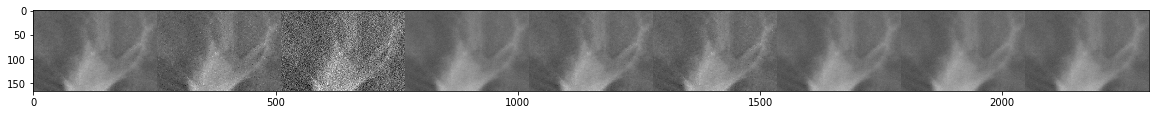

In [317]:
# Bad ones -> 19, 54

index = 54#random.randint(0, 54-1)
#index = 2
a = np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_patches/dbt_real_patches_"+str(index)+".npy")
b = np.load("/media/dril/Windows/newrecon2/newrecon/dbt_real_patches_values/dbt_real_patches_values_"+str(index)+".npy")
print(a.shape, index)

idx = np.random.permutation(len(a))
a = a[idx]
b = b[idx]

plt.figure(figsize=(20,10))
#print(b)
plt.imshow(np.concatenate(a[:, 2, :, :], axis=-1), cmap='gray')

values = np.zeros(len(a))

In [ ]:
# Bad index -> 2, 6, 23, 18, 20, 36, 54
# For paper -> 10, 16, 33 (maybe)

In [316]:
values[7] = 5
values[5] = 4
values[2]  = 3
values[3]  = 2
values[8]  = 1

np.save("index-b-"+str(index)+".npy",   idx)
np.save("reorder-b-"+str(index)+".npy", b)
np.save("values-b-"+str(index)+".npy",  values)

In [242]:
p = np.load("reorder-b-16.npy")
print(p)

[-0.586 -0.335 -0.132  0.    -0.36  -0.215 -0.356 -0.228 -0.433]


In [ ]:
# Lesion Location information

1  1692, 1034, 34
3  2043, 280,  18
3  2124, 1146, 17
3  1272, 236,  32
6  1293, 440,  16
7  1708, 496,  44
7  941, 1100,  13
10 874, 1018,  28
10 1922, 734,  33 
10 1957, 413,  38
10 2018, 556,  37
10 1961, 470,  7
11 1298, 661,  22
12 
13 1628, 348,  34
13 1797, 854,  34
13 1622, 349,  34
13 1596, 510,  31
13 1550, 669,  37
16 
17  
19 686, 1125, 20
21 732, 464,  9
23 
25 1985, 576,  64
25 1440, 256,  57
25 1864, 1040, 36
27 1429. 925,  64
27 1278, 829,  64
29 1246, 977,  21
29 1380, 905,  19
31
33 1104, 666,  24
35 1670, 725,  17
37 1128, 877,  56
39 
41 1084, 934,  42
43 
44 1480, 970,  19
45 1638, 610,  47
47 1062, 646,  23
47 1301, 564,  23
47 1870, 625,  23
50 
52 
54 706, 1162,  27
55 
56 (bad)
57 (bad)
58 
59 841, 1038,  32
60 554, 553,   28
60 468, 830,   22
61 
62 
64 1948, 854,  22
65 1820, 600,  25
66 1510, 328,  40
66 1328, 1001, 20
66 1950, 630,  46 (test)
66 1544, 529,  37
67 1672, 542,  42
67 2138, 612,  36
67 1797, 694,  35
67 1164, 737,  33 (test)
68                (train) 
69                (train)
70 1341, 762, 10
71 1433, 769, 14  (train)
72                (train)
73                (train)
74 2302, 457, 28  (test)
75 2107, 777, 40  (test)
76                (train)


In [ ]:
# Code to get the patches

#todo = [15, 16, 19, 20, 27, 29, 31, 35]

for i in range(1, 77):
    #if i not in todo:
    #    continue
    #todo = [15, 16, 19, 20, 27, 29, 31, 35]
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(i)+".raw.npy")
    if len(allfiles) == 0:
        continue
    
    mainfile = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_"+str(i)+".raw")[0]
    
    all_vols   = np.zeros([len(allfiles)+1, 64, 1200, 3000], dtype='float16')
    all_index  = []
    all_values = []
    
    temp = np.fromfile(mainfile, dtype='float32')
    temp = np.reshape(temp, [64, 1200, 3000])
    all_vols[0, :, :, :] = temp
    all_index.append(i)
    all_values.append(-0)
    
    counter = 1
    for f in allfiles:
        #a = np.fromfile(f, dtype='float32')
        a     = np.load(f)
        a     = np.reshape(a, [64, 1200, 3000])
        all_vols[counter, :, :, :] = a
        
        index = int(f.split("/")[-1].split("_")[-1].split(".")[0])
        value = float(f.split("/")[-1].split("_")[-2])
        
        all_index.append(index)
        all_values.append(value)
        print(index, value, a.shape, f)
        counter = counter+1
    
    total_count   = 50
    all_locations = []
    
    # Get all Locations
    while(True):
        ix = np.random.randint(256, 1200-256)
        iy = np.random.randint(256, 3000-256)
        iz = np.random.randint(10, 54)
        
        tempx = all_vols[0][iz, ix:ix+256, iy:iy+256]
        
        if np.count_nonzero(tempx.flatten())*1.0/(256*256) < 0.9:
            continue
        
        all_locations.append([ix, iy, iz])
        if len(all_locations) == total_count:
            break
    
    # Get patches
    for k in range(len(all_vols)):
        y_array = np.zeros([total_count, 256, 256, 1], dtype='float16')
        counter = 0
        
        for p in all_locations:
            iz = p[2]
            ix = p[0]
            iy = p[1]
            
            tempy   = all_vols[k][iz, ix:ix+256, iy:iy+256]
            y_array[counter, :, :, 0] = tempy
            counter = counter+1
        np.save("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(all_index[k])+'_'+str(all_values[k])+'.npy', y_array)
    
    

In [84]:
a = np.load('/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/75_0.npy')
b = np.load('/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/75_-0.169.npy')
print(a.shape, b.shape)

(50, 256, 256, 1) (50, 256, 256, 1)


In [4]:
# For reading the training data

train_list = [1, 3, 6, 7, 11, 12, 13, 16, 17, 31, 33, 35, 37, 39, 41, 43, 50, 52, 55,  68, 69, 70, 71, 72, 73, 76]
val_list   = [19, 21, 23, 25, 27, 29, 61, 62, 64, 65]
test_list  = [10, 44, 45, 47, 54, 58, 59, 60, 66, 67, 74, 75]


x_array = np.zeros([10650, 256, 256, 1], dtype='float16')
z_array = np.zeros([10650, 1], dtype='float16')
y_array = np.zeros([10650, 256, 256, 1], dtype='float16')


x_val_array = np.zeros([3950, 256, 256, 1], dtype='float16')
z_val_array = np.zeros([3950, 1], dtype='float16')
y_val_array = np.zeros([3950, 256, 256, 1], dtype='float16')

count = 0
for t in train_list:
    #print(t)
    maintemp = np.load("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_*-*.npy")
    for f in allfiles:
        temp = np.load(f)
        
        #print(f, temp.shape, float(f.split("/")[-1].split("_")[1][:-4]))
        y_array[count: count+50, :, :, :] = temp
        x_array[count: count+50, :, :, :] = maintemp
        z_array[count: count+50, :]       = np.ones([50, 1])*float(f.split("/")[-1].split("_")[1][:-4])
        count = count+50

print(x_array.shape, y_array.shape, z_array.shape, count)




count = 0
for t in val_list:
    #print(t)
    maintemp = np.load("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_0.npy")
    #maintemp = np.load(mainfile)
    
    allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/PATCHES/"+str(t)+"_*-*.npy")
    for f in allfiles:
        temp = np.load(f)
        
        #print(f, temp.shape, float(f.split("/")[-1].split("_")[1][:-4]))
        y_val_array[count: count+50, :, :, :] = temp
        x_val_array[count: count+50, :, :, :] = maintemp
        z_val_array[count: count+50, :]       = np.ones([50, 1])*float(f.split("/")[-1].split("_")[1][:-4])
        count = count+50
        
print(x_val_array.shape, y_val_array.shape, z_val_array.shape, count)

(10650, 256, 256, 1) (10650, 256, 256, 1) (10650, 1) 10650
(3950, 256, 256, 1) (3950, 256, 256, 1) (3950, 1) 3950


In [ ]:

model       = unet_no_dense()
checkpoints = ModelCheckpoint('miccai-3.h5', 
                                             monitor='val_loss', verbose=0, save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)

model.fit([x_array, z_array], y_array,
          validation_data=([x_val_array, z_val_array], y_val_array), 
          batch_size=8, 
          epochs=10000, 
          callbacks=[checkpoints])

In [ ]:
alllimgs = []

mainfile = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_75.raw")[0]
allfiles = glob.glob("/media/dril/My Passport/REAL-DBT-PROJECTIONS/RECONS/*_75.raw.npy")
allfiles.sort()

#allfiles.append(mainfile)

tx = 2107
ty = 777
tz = 40

allimgs = []

index = 0
for i in range(0, len(allfiles)):
    if index != 0:
        a   = np.load(allfiles[i-1])
        a   = np.reshape(a, [64, 1200, 3000])
        print(allfiles[i-1])
    else:
        a = np.fromfile(mainfile, dtype='float32')
        a = np.reshape(a, [64, 1200, 3000])
        print(mainfile)
    
    img = a[tz, ty-128:ty+128, tx-128:tx+128].astype('float32')
    allimgs.append(img)
    t1  = img*mask
    t2  = img*mask1
    cnr = (np.mean(t1.flatten())-np.mean(t2.flatten()))/(np.var(t2.flatten()))
    print(np.mean(t1.flatten()), np.mean(t2.flatten()), np.var(t2.flatten()), cnr)
    index = index+1
    #
    #allimgs.append(img)

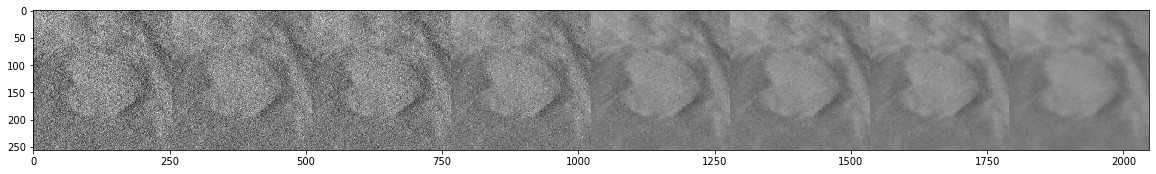

In [222]:
#plt.imshow(a[39, 777-128:777+128, 2107-128:2107+128].astype('float32'), cmap='gray')
#index = random.randint(0, len(allimgs)-1)
#print()
#plt.imshow(img.astype('float32'), cmap='gray')
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate(allimgs, axis=-1).astype('float32'), cmap='gray')

In [199]:
import numpy as np

a, b = 1, 1
n = 256
r = 25

y,x   = np.ogrid[-a:n-a, -b:n-b]
mask  = (x-128)*(x-128) + (y-128)*(y-128) <= r*r#(x-128)*(x-128) + (y-128)*(y-128) <= r*r
mask1 = ndimage.binary_dilation(mask, iterations=20)

mask  = mask.astype('float32')
mask1 = mask1.astype('float32')

mask1 = mask1-mask

t1 = img*mask
t2 = img*mask1

#t1[t1 == 0] = np.min(img.flatten())
#t2[t2 == 0] = np.min(img.flatten())

print(mask.shape, mask1.shape)

# t1 = np.multiply(mask, img)
# t2 = np.multiply(mask1, img)
# plt.imshow(np.concatenate([t1, t2], axis=-1), cmap='gray')

(256, 256) (256, 256)


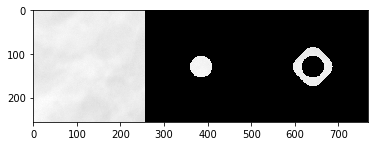

In [200]:
plt.imshow(np.concatenate([img, t1, t2]).T, cmap='gray')
#print(t1.dtype)
#plt.hist(t2.flatten())
#plt.imshow(img, cmap='gray')

In [ ]:
cnr = (np.mean(t1.flatten())-np.mean(t2.flatten()))/(np.var(t2.flatten()))

print(np.mean(t1.flatten()))
print(np.mean(t2.flatten()))
print(np.var(t2.flatten()))

print(cnr)

In [225]:
result = model.predict([x_val_array, z_val_array], batch_size=8)
print(result.shape, y_val_array.shape)

(3950, 256, 256, 1) (3950, 256, 256, 1)


847 [-0.405]


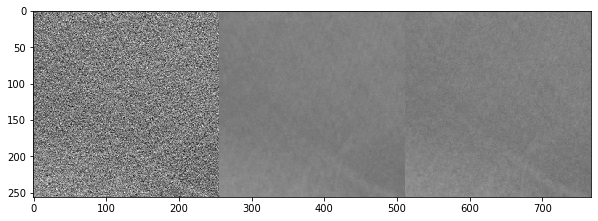

In [244]:
index = random.randint(0, len(x_val_array)-1)
print(index, z_val_array[index])
plt.figure(figsize=(10,5))
#plt.imshow(np.concatenate(x_val_array[index, :, :, 0], result[index, :, :, 0], y_val_array[index, :, :, 0]).T, cmap='gray')
plt.imshow(np.concatenate([x_val_array[index, :, :, 0], result[index, :, :, 0], y_val_array[index, :, :, 0]]).astype('float32').T, cmap='gray')
#plt.imshow(x_val_array[index, :, :, 0], cmap='gray')